In [1]:
pip install pydicom

Note: you may need to restart the kernel to use updated packages.


In [2]:
!mkdir -p /tmp/pip/cache/

In [3]:
!cp '/kaggle/input/module70/my_packages/efficientnet_pytorch-0.7.1.mp4' '/tmp/pip/cache/efficientnet_pytorch-0.7.1.tar.gz'
!cp '/kaggle/input/module70/my_packages/pretrainedmodels-0.7.4.mp4' '/tmp/pip/cache/pretrainedmodels-0.7.4.tar.gz'
!cp '/kaggle/input/module70/my_packages/pbr-6.0.0.mp4' '/tmp/pip/cache/pbr-6.0.0.tar.gz'
!cp '/kaggle/input/module70/my_packages/segmentation_models_pytorch-0.3.3.mp4' '/tmp/pip/cache/segmentation_models_pytorch-0.3.3.tar.gz'
!cp '/kaggle/input/module70/my_packages/timm-0.9.2.mp4' '/tmp/pip/cache/timm-0.9.2.tar.gz'

In [4]:
!pip install /kaggle/input/module70/my_packages/munch-4.0.0-py2.py3-none-any.whl

Processing /kaggle/input/module70/my_packages/munch-4.0.0-py2.py3-none-any.whl


In [5]:
!pip install /kaggle/input/pydicom/pydicom-2.4.4-py3-none-any.whl

Processing /kaggle/input/pydicom/pydicom-2.4.4-py3-none-any.whl
  Attempting uninstall: pydicom
    Found existing installation: pydicom 3.0.0
    Uninstalling pydicom-3.0.0:
      Successfully uninstalled pydicom-3.0.0


In [6]:
!pip install --no-index '/tmp/pip/cache/pbr-6.0.0.tar.gz'
# !pip install --no-index '/tmp/pip/cache/munch-4.0.0.tar.gz'
!pip install --no-index '/tmp/pip/cache/pretrainedmodels-0.7.4.tar.gz'
!pip install --no-index '/tmp/pip/cache/efficientnet_pytorch-0.7.1.tar.gz'

!pip uninstall timm -y
!pip install --no-index --no-build-isolation '/tmp/pip/cache/timm-0.9.2.tar.gz'
!pip install --no-index --no-build-isolation '/tmp/pip/cache/segmentation_models_pytorch-0.3.3.tar.gz'

Processing /tmp/pip/cache/pbr-6.0.0.tar.gz
  Preparing metadata (setup.py) ... - done
  Created wheel for pbr: filename=pbr-6.0.0-py2.py3-none-any.whl size=107509 sha256=391aa697ca1de1e08d62c43e7764ccc4b5516a96f80ae270dead48979e2a43ca
  Stored in directory: /root/.cache/pip/wheels/a7/ac/63/4e8c7c0b6d7683f79b8bd349e24f44dea6e14fa52dba14e737
Successfully built pbr
Processing /tmp/pip/cache/pretrainedmodels-0.7.4.tar.gz
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=35adbbb562d779bd2421ae5b6036e5ae43c36bfcf9273245a60f0394d0034993
  Stored in directory: /root/.cache/pip/wheels/23/bc/31/6c80447d98e268b3a8f268ddd871057962c789c830779c16eb
Successfully built pretrainedmodels
Processing /tmp/pip/cache/efficientnet_pytorch-0.7.1.tar.gz
  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha2

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import glob
from tqdm import tqdm
import gc
import pydicom

import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from fastai.vision.all import *
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
CV = 5
SEED = 777
fold = 1
PATCH_SIZE = 512
patch_size = 90
TH = .5
SEG_TRAIN = False
SEG = {
    'BS':16,
    'LR':5e-4,
    'EPOCHS':10
}
INF = {
    'BS':64,
    'LR':1e-5,
    'EPOCHS':10
}

In [9]:
class myUNet3(nn.Module):
    def __init__(self):
        super(myUNet3, self).__init__()

        self.UNet = smp.Unet(
            encoder_name="resnet18",
            classes=5,
            in_channels=1
        ).to(device)

    def forward(self,X):
        x = self.UNet(X)
#       MinMaxScaling along the class plane to generate a heatmap
        min_values = x.view(-1,5,PATCH_SIZE*PATCH_SIZE).min(-1)[0].view(-1,5,1,1) # Bug, I've been MinMaxScaling with the wrong values
        max_values = x.view(-1,5,PATCH_SIZE*PATCH_SIZE).max(-1)[0].view(-1,5,1,1)
        x = (x - min_values)/(max_values - min_values)

        return x

In [10]:
idx_map = torch.stack([torch.arange(PATCH_SIZE)]*PATCH_SIZE).to(device)
idx_map = torch.stack([idx_map,idx_map.T]).view(1,1,2,PATCH_SIZE,PATCH_SIZE)
class myLoss3(nn.Module):
    def __init__(
            self,
            alpha=.5
        ):
        super().__init__()
        self.alpha = alpha

    def clone(self):
        return myLoss(self.alpha)

    def forward(
            self,
            y,# Predictions
            t # Targets
        ):
        mask_pred = y
        _,mask_true = t
#       The heatmap Loss as the distance between the predicted Normal and the ideal one
#       Let's define the ideal heatmaps as the Normal distributions
#       centered on the diagnostic centers with s2 = PATCH_SIZE/8
        s2 = s2 = torch.as_tensor([PATCH_SIZE/8]*5)
#       Then the corresponding alphas and normalization constants would be
        A = -1/(2*s2).to(device)
        K = 1/torch.sqrt(2*math.pi*s2).to(device)
#       Predicted heatmaps rescaling
        mask_pred = mask_pred*K.view(1,5,1,1)
#       Ideal heatmaps
        mask = idx_map - mask_true.view(-1,5,2,1,1)
        mask = torch.exp((A.view(-1,5,1,1,1)*mask*mask).sum(2))*K.view(-1,5,1,1)
#       Distance
        D = 1 - ((mask*mask_pred).sum())**2/((mask*mask).sum()*(mask_pred*mask_pred).sum())

        return D


In [11]:
with open("/kaggle/input/segmodel/SEG_SCS_1.pkl", 'rb') as f:
      model3=pickle.load(f)


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [12]:
class myUNet2(nn.Module):
    def __init__(self):
        super(myUNet2, self).__init__()

        self.UNet = smp.Unet(
            encoder_name="resnet18",
            classes=2,
            in_channels=1
        ).to(device)

    def forward(self,X):
        x = self.UNet(X)
#       MinMaxScaling along the class plane to generate a heatmap
        min_values = x.view(-1,2,PATCH_SIZE*PATCH_SIZE).min(-1)[0].view(-1,2,1,1) # Bug, I've been MinMaxScaling with the wrong values
        max_values = x.view(-1,2,PATCH_SIZE*PATCH_SIZE).max(-1)[0].view(-1,2,1,1)
        x = (x - min_values)/(max_values - min_values)

        return x

In [13]:
idx_map = torch.stack([torch.arange(PATCH_SIZE)]*PATCH_SIZE).to(device)
idx_map = torch.stack([idx_map,idx_map.T]).view(1,1,2,PATCH_SIZE,PATCH_SIZE)
class myLoss2(nn.Module):
    def __init__(
            self,
            alpha=.5
        ):
        super().__init__()
        self.alpha = alpha

    def clone(self):
        return myLoss(self.alpha)

    def forward(
            self,
            y,# Predictions
            t # Targets
        ):
        mask_pred = y
        _,mask_true = t
#       The heatmap Loss as the distance between the predicted Normal and the ideal one
#       Let's define the ideal heatmaps as the Normal distributions
#       centered on the diagnostic centers with s2 = PATCH_SIZE/8
        s2 = s2 = torch.as_tensor([PATCH_SIZE/8]*2)
#       Then the corresponding alphas and normalization constants would be
        A = -1/(2*s2).to(device)
        K = 1/torch.sqrt(2*math.pi*s2).to(device)
#       Predicted heatmaps rescaling
        mask_pred = mask_pred*K.view(1,2,1,1)
#       Ideal heatmaps
        mask = idx_map - mask_true.view(-1,2,2,1,1)
        mask = torch.exp((A.view(-1,2,1,1,1)*mask*mask).sum(2))*K.view(-1,2,1,1)
#       Distance
        D = 1 - ((mask*mask_pred).sum())**2/((mask*mask).sum()*(mask_pred*mask_pred).sum())

        return D


In [14]:
with open("/kaggle/input/segmodel/SEG_1_SS.pkl", 'rb') as f:
      model2=pickle.load(f)

In [15]:
class myUNet(nn.Module):
    def __init__(self):
        super(myUNet, self).__init__()

        self.UNet = smp.Unet(
            encoder_name="resnet18",
            classes=5,
            in_channels=1
        ).to(device)

    def forward(self,X):
        x = self.UNet(X)
#       MinMaxScaling along the class plane to generate a heatmap
        min_values = x.view(-1,5,PATCH_SIZE*PATCH_SIZE).min(-1)[0].view(-1,5,1,1) # Bug, I've been MinMaxScaling with the wrong values
        max_values = x.view(-1,5,PATCH_SIZE*PATCH_SIZE).max(-1)[0].view(-1,5,1,1)
        x = (x - min_values)/(max_values - min_values)

        return x

In [16]:
idx_map = torch.stack([torch.arange(PATCH_SIZE)]*PATCH_SIZE).to(device)
idx_map = torch.stack([idx_map,idx_map.T]).view(1,1,2,PATCH_SIZE,PATCH_SIZE)
class myLoss(nn.Module):
    def __init__(
            self,
            alpha=.5
        ):
        super().__init__()
        self.alpha = alpha

    def clone(self):
        return myLoss(self.alpha)

    def forward(
            self,
            y,# Predictions
            t # Targets
        ):
        mask_pred = y
        _,mask_true = t
#       The heatmap Loss as the distance between the predicted Normal and the ideal one
#       Let's define the ideal heatmaps as the Normal distributions
#       centered on the diagnostic centers with s2 = PATCH_SIZE/8
        s2 = s2 = torch.as_tensor([PATCH_SIZE/8]*5)
#       Then the corresponding alphas and normalization constants would be
        A = -1/(2*s2).to(device)
        K = 1/torch.sqrt(2*math.pi*s2).to(device)
#       Predicted heatmaps rescaling
        mask_pred = mask_pred*K.view(1,5,1,1)
#       Ideal heatmaps
        mask = idx_map - mask_true.view(-1,5,2,1,1)
        mask = torch.exp((A.view(-1,5,1,1,1)*mask*mask).sum(2))*K.view(-1,5,1,1)
#       Distance
        D = 1 - ((mask*mask_pred).sum())**2/((mask*mask).sum()*(mask_pred*mask_pred).sum())

        return D



In [17]:
with open("/kaggle/input/segmodel/SEG_1.pkl", 'rb') as f:
      model1=pickle.load(f)

In [18]:
import os
import pandas as pd

# データセットのパス
base_dir = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/'

# リストを初期化
data = []

# 一番上の階層（study_id）のフォルダをたどる
for study_id in os.listdir(base_dir):
    study_path = os.path.join(base_dir, study_id)
    if os.path.isdir(study_path):
        # 二番目の階層（series_id）のフォルダをたどる
        for series_id in os.listdir(study_path):
            series_path = os.path.join(study_path, series_id)
            if os.path.isdir(series_path):
                # 三番目の階層（〇〇.dcm ファイル）をたどる
                for filename in os.listdir(series_path):
                    if filename.endswith('.dcm'):
                        # 〇〇.dcm の〇〇部分（instance_number）を抽出
                        instance_number = filename.split('.')[0]
                        # データを追加
                        data.append([study_id, series_id, instance_number])

# pandas DataFrameを作成
df = pd.DataFrame(data, columns=['study_id', 'series_id', 'instance_number'])

# DataFrameの表示
print(df)

    study_id   series_id instance_number
0   44036939  3844393089              12
1   44036939  3844393089              18
2   44036939  3844393089               9
3   44036939  3844393089              22
4   44036939  3844393089              25
..       ...         ...             ...
92  44036939  2828203845               6
93  44036939  2828203845              16
94  44036939  2828203845              20
95  44036939  2828203845               3
96  44036939  2828203845              13

[97 rows x 3 columns]


In [19]:
# new_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/sample_submission.csv')

df_meta_f = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_series_descriptions.csv')
df_meta_f.tail()

df = df.astype('int64')

all_df = pd.merge(df, df_meta_f, on=['study_id', 'series_id'], how='inner')

s_all_df=all_df[all_df['series_description']=='Sagittal T1']

a_all_df=all_df[all_df['series_description']=='Axial T2']

s2_all_df=all_df[all_df['series_description']=='Sagittal T2/STIR']


In [20]:
import os
import numpy as np

# データフレームをコピーして操作
s_all_df_copy = s_all_df.copy()

# x_pos カラムを NaN で初期化
s_all_df_copy['x_pos'] = None
s_all_df_copy['y_pos'] = None
s_all_df_copy['z_pos'] = None
s_all_df_copy['pixel_sp_z'] = None
s_all_df_copy['pixel_sp_y'] = None

# 各行を処理
for idx, row in s_all_df_copy.iterrows():
    # DICOMファイルのパスを構築
    dicom_file_path = f"/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/{row['study_id']}/{row['series_id']}/{row['instance_number']}.dcm"

    # DICOMファイルを読み込む
    dicom_data = pydicom.dcmread(dicom_file_path)

    # 'Image Position (Patient)' の x 座標を取得して x_pos カラムに格納
    s_all_df_copy.loc[idx, 'x_pos'] = dicom_data.ImagePositionPatient[0]
    s_all_df_copy.loc[idx, 'y_pos'] = dicom_data.ImagePositionPatient[1]
    s_all_df_copy.loc[idx, 'z_pos'] = dicom_data.ImagePositionPatient[2]
    s_all_df_copy.loc[idx, 'pixel_sp_z']=dicom_data.PixelSpacing[0]
    s_all_df_copy.loc[idx, 'pixel_sp_y']=dicom_data.PixelSpacing[1]


# 結果を表示
print(s_all_df_copy)


    study_id   series_id  instance_number series_description     x_pos  \
72  44036939  2828203845               12        Sagittal T1   17.3556   
73  44036939  2828203845               18        Sagittal T1 -0.625948   
74  44036939  2828203845                9        Sagittal T1   26.3463   
75  44036939  2828203845               22        Sagittal T1  -12.6136   
76  44036939  2828203845               25        Sagittal T1  -21.6044   
77  44036939  2828203845               14        Sagittal T1   11.3617   
78  44036939  2828203845               11        Sagittal T1   20.3525   
79  44036939  2828203845               24        Sagittal T1  -18.6075   
80  44036939  2828203845               23        Sagittal T1  -15.6106   
81  44036939  2828203845               10        Sagittal T1   23.3494   
82  44036939  2828203845               17        Sagittal T1   2.37097   
83  44036939  2828203845                1        Sagittal T1   50.3217   
84  44036939  2828203845              

In [21]:
import os
import numpy as np

# データフレームをコピーして操作
a_all_df_copy = a_all_df.copy()

# x_pos カラムを NaN で初期化
a_all_df_copy['x_pos'] = None
a_all_df_copy['y_pos'] = None
a_all_df_copy['z_pos'] = None
a_all_df_copy['pixel_sp_z'] = None
a_all_df_copy['pixel_sp_y'] = None

# 各行を処理
for idx, row in a_all_df_copy.iterrows():
    # DICOMファイルのパスを構築
    dicom_file_path = f"/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/{row['study_id']}/{row['series_id']}/{row['instance_number']}.dcm"

    # DICOMファイルを読み込む
    dicom_data = pydicom.dcmread(dicom_file_path)
    H,W = dicom_data.pixel_array.shape


    # 'Image Position (Patient)' の x 座標を取得して x_pos カラムに格納
    a_all_df_copy.loc[idx, 'x_pos'] = dicom_data.ImagePositionPatient[0]
    a_all_df_copy.loc[idx, 'y_pos'] = dicom_data.ImagePositionPatient[1]
    a_all_df_copy.loc[idx, 'z_pos'] = dicom_data.ImagePositionPatient[2]
    a_all_df_copy.loc[idx, 'pixel_sp_z']=dicom_data.PixelSpacing[0]
    a_all_df_copy.loc[idx, 'pixel_sp_y']=dicom_data.PixelSpacing[1]
    a_all_df_copy.loc[idx, 'H'] = H
    a_all_df_copy.loc[idx, 'W'] = W
    a_all_df_copy.loc[idx, 'mean_bfr_cut_y'] = H/2
    a_all_df_copy.loc[idx, 'mean_bfr_cut_x'] = W/2
    a_all_df_copy.loc[idx,'o0']=dicom_data.ImageOrientationPatient[0]
    a_all_df_copy.loc[idx,'o1']=dicom_data.ImageOrientationPatient[1]
    a_all_df_copy.loc[idx,'o2']=dicom_data.ImageOrientationPatient[2]
    a_all_df_copy.loc[idx,'o3']=dicom_data.ImageOrientationPatient[3]
    a_all_df_copy.loc[idx,'o4']=dicom_data.ImageOrientationPatient[4]
    a_all_df_copy.loc[idx,'o5']=dicom_data.ImageOrientationPatient[5]


# 結果を表示
print(a_all_df_copy)


    study_id   series_id  instance_number series_description    x_pos  \
25  44036939  3481971518               12           Axial T2 -72.7899   
26  44036939  3481971518               18           Axial T2 -73.2899   
27  44036939  3481971518                9           Axial T2   -72.54   
28  44036939  3481971518               22           Axial T2 -73.6232   
29  44036939  3481971518               25           Axial T2 -73.8732   
30  44036939  3481971518               39           Axial T2 -75.0398   
31  44036939  3481971518               45           Axial T2 -75.5397   
32  44036939  3481971518               14           Axial T2 -72.9566   
33  44036939  3481971518               11           Axial T2 -72.7066   
34  44036939  3481971518               44           Axial T2 -75.4564   
35  44036939  3481971518               24           Axial T2 -73.7899   
36  44036939  3481971518               34           Axial T2 -74.6231   
37  44036939  3481971518               29          

In [22]:
a_all_df_copy = a_all_df_copy.reset_index(drop=True)


a_all_df=a_all_df_copy


In [23]:
import torch

# (OUT > 0.5)[0][1] がテンソルマスクだと仮定
a_all_df_copy = a_all_df.copy()
for j in range(len(a_all_df)):

  # a_all_df[['study_id', 'series_id', 'instance_number']] = a_all_df[['study_id', 'series_id', 'instance_number']].astype(int)
  image=pydicom.dcmread("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/"+str(a_all_df_copy.iloc[j]["study_id"])+"/"+str(a_all_df_copy.iloc[j]["series_id"])+"/"+str(a_all_df_copy.iloc[j]["instance_number"])+".dcm").pixel_array
  dicom=pydicom.dcmread("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/"+str(a_all_df_copy.iloc[j]["study_id"])+"/"+str(a_all_df_copy.iloc[j]["series_id"])+"/"+str(a_all_df_copy.iloc[j]["instance_number"])+".dcm")
  H,W = image.shape
  a_all_df_copy.loc[j, 'H'] = H
  a_all_df_copy.loc[j, 'W'] = W
  a_all_df_copy.loc[j,'o0']=dicom.ImageOrientationPatient[0]
  a_all_df_copy.loc[j,'o1']=dicom.ImageOrientationPatient[1]
  a_all_df_copy.loc[j,'o2']=dicom.ImageOrientationPatient[2]
  a_all_df_copy.loc[j,'o3']=dicom.ImageOrientationPatient[3]
  a_all_df_copy.loc[j,'o4']=dicom.ImageOrientationPatient[4]
  a_all_df_copy.loc[j,'o5']=dicom.ImageOrientationPatient[5]
  a_all_df_copy.loc[j, 'H_cut'] = 0
  a_all_df_copy.loc[j, 'W_cut'] = 0

  # centers = torch.as_tensor([x for x in row[coor]]).view(5,2).float()
  # By plane resizing I've been distorting the proportions
  if H > W:
      d = W
      h = (H - d)//2
      image = image[h:h+d]
      a_all_df_copy.loc[j, 'H_cut'] = h
      # centers[:,1] -= h
      H = W
  elif H < W:
      d = H
      w = (W - d)//2
      image = image[:,w:w+d]
      a_all_df_copy.loc[j, 'W_cut'] = w
      # centers[:,0] -= w
      W = H
  image = cv2.resize(image,(PATCH_SIZE,PATCH_SIZE))
  image = torch.as_tensor(image/np.max(image)).unsqueeze(0).float()
  image=image.to(device)
  OUT = model2(image.unsqueeze(0)).cpu().detach()
  for i in range(2):
    mask = (OUT > 0.5)[0][i]  # 512x512のテンソル

    # Trueのピクセル座標を取得（y座標とx座標のペアとして取得）
    true_pixels = torch.nonzero(mask)

    # 平均座標を計算
    mean_yx = true_pixels.float().mean(dim=0)

    # 平均座標を表示
    mean_y, mean_x = mean_yx[0], mean_yx[1]


    a_all_df_copy.loc[j, f'mean_y_{i}']=mean_y.item()
    a_all_df_copy.loc[j, f'mean_x_{i}']=mean_x.item()
    print(f"Mean coordinates: (y, x) = ({0-mean_y.item()}, {mean_x.item()})")

    # a_all_df_copy.loc[j, f'z_pos_{i}'] = a_all_df.loc[j, 'pixel_sp_z'] * (0 - mean_y.item()) + a_all_df.loc[j, 'z_pos']

# # DataFrameを保存するパス
# save_path = '/content/drive/MyDrive/RSNA_csv/dataset_2_axial.pkl'

# # DataFrameをpkl形式で保
# a_all_df.to_pickle(save_path)

# print(f"DataFrame has been saved to {save_path}")


Mean coordinates: (y, x) = (-306.44927978515625, 336.14129638671875)
Mean coordinates: (y, x) = (-298.0793151855469, 273.4689636230469)
Mean coordinates: (y, x) = (-290.5274658203125, 326.4248962402344)
Mean coordinates: (y, x) = (-277.9794616699219, 269.43109130859375)
Mean coordinates: (y, x) = (-318.8768005371094, 331.6702880859375)
Mean coordinates: (y, x) = (-314.49462890625, 277.3978576660156)
Mean coordinates: (y, x) = (-263.2036437988281, 302.3927307128906)
Mean coordinates: (y, x) = (-261.4688720703125, 257.9194030761719)
Mean coordinates: (y, x) = (-239.1666717529297, 283.8461608886719)
Mean coordinates: (y, x) = (-235.62815856933594, 223.94224548339844)
Mean coordinates: (y, x) = (-239.87762451171875, 264.8356628417969)
Mean coordinates: (y, x) = (-237.8817138671875, 229.51254272460938)
Mean coordinates: (y, x) = (-263.2823791503906, 463.0140380859375)
Mean coordinates: (y, x) = (-298.86566162109375, 178.1641845703125)
Mean coordinates: (y, x) = (-299.730224609375, 337.85971

In [24]:
a_all_df=a_all_df_copy

import torch

# 各マスクの座標を元の画像サイズに戻すコード
for j in range(len(a_all_df)):
    # 元の画像サイズ
    H = a_all_df.loc[j, 'H']
    W = a_all_df.loc[j, 'W']

    # 512にリサイズされた画像のサイズ
    resized_size = 512

    # 高さと幅のスケール（リサイズ前の座標に戻すためのスケール）
    if H<W:
      scale_y = H / resized_size
      scale_x = H / resized_size
    elif H>W:
      scale_y = W / resized_size
      scale_x = W / resized_size
    else:
      scale_y = W / resized_size
      scale_x = H / resized_size

    # 5つのマスクについて座標を戻す
    for i in range(2):
        # リサイズ後の座標を取得
        mean_y_resized =a_all_df.loc[j, f'mean_y_{i}']
        mean_x_resized =a_all_df.loc[j, f'mean_x_{i}']

        # リサイズ前の座標に戻す（スケールを掛ける）
        mean_bfr_y = mean_y_resized * scale_y
        mean_bfr_x = mean_x_resized * scale_x

        # 戻した座標を新しいカラムに格納
        a_all_df.loc[j, f'mean_bfr_y_{i}'] = mean_bfr_y
        a_all_df.loc[j, f'mean_bfr_x_{i}'] = mean_bfr_x



In [25]:
import torch

# 各マスクの切り取る前の座標を計算して新しいカラムに格納
for j in range(len(a_all_df)):
    # H_cut, W_cut はどれくらい切り取られたかを表す（NaNの場合は切り取りなし）
    H_cut = a_all_df.loc[j, 'H_cut'] if not pd.isna(a_all_df.loc[j, 'H_cut']) else 0
    W_cut = a_all_df.loc[j, 'W_cut'] if not pd.isna(a_all_df.loc[j, 'W_cut']) else 0

    for i in range(2):
        # リサイズ前の平均座標を取得
        mean_bfr_y = a_all_df.loc[j, f'mean_bfr_y_{i}']
        mean_bfr_x = a_all_df.loc[j, f'mean_bfr_x_{i}']

        # 切り取る前の座標を計算（H_cutとW_cutを戻す）
        mean_bfr_cut_y = mean_bfr_y + H_cut
        mean_bfr_cut_x = mean_bfr_x + W_cut

        # 切り取る前の座標を新しいカラムに格納
        a_all_df.loc[j, f'mean_bfr_cut_y_{i}'] = mean_bfr_cut_y
        a_all_df.loc[j, f'mean_bfr_cut_x_{i}'] = mean_bfr_cut_x


In [26]:
import numpy as np

# 3次元座標を計算してカラムに格納するコード
for j in range(len(a_all_df)):
    # DICOMのメタデータ
    x_pos = a_all_df.loc[j, 'x_pos']
    y_pos = a_all_df.loc[j, 'y_pos']
    z_pos = a_all_df.loc[j, 'z_pos']

    o0, o1, o2 = a_all_df.loc[j, ['o0', 'o1', 'o2']]  # 行方向ベクトル (ImageOrientationPatientの0〜2番目)
    o3, o4, o5 = a_all_df.loc[j, ['o3', 'o4', 'o5']]  # 列方向ベクトル (ImageOrientationPatientの3〜5番目)

    pixel_sp_y = a_all_df.loc[j, 'pixel_sp_y']  # 行方向のPixelSpacing
    pixel_sp_z = a_all_df.loc[j, 'pixel_sp_z']  # 列方向のPixelSpacing

    # 行方向ベクトル
    row_direction = np.array([o0, o1, o2])
    # 列方向ベクトル
    col_direction = np.array([o3, o4, o5])

    # 各マスクに対して3次元座標を計算
    for i in range(2):
        # ピクセル座標を取得
        mean_y = a_all_df.loc[j, f'mean_bfr_cut_y_{i}']  # 行方向（R）
        mean_x = a_all_df.loc[j, f'mean_bfr_cut_x_{i}']  # 列方向（C）

        # 3次元座標を計算
        patient_pos = np.array([x_pos, y_pos, z_pos]) + \
                      (pixel_sp_y * mean_x) * row_direction + \
                      (pixel_sp_z * mean_y) * col_direction

        # 計算した3次元座標をカラムに格納
        a_all_df.loc[j, f'xx_{i}'] = patient_pos[0]
        a_all_df.loc[j, f'yy_{i}'] = patient_pos[1]
        a_all_df.loc[j, f'zz_{i}'] = patient_pos[2]


In [27]:
a_all_df = a_all_df.rename(columns={
    'xx_0': 'xx_0_axial',
    'yy_0': 'yy_0_axial',
    'zz_0': 'zz_0_axial',
    'xx_1': 'xx_1_axial',
    'yy_1': 'yy_1_axial',
    'zz_1': 'zz_1_axial'
})

In [28]:
import os
import numpy as np

# データフレームをコピーして操作
s2_all_df_copy = s2_all_df.copy()

# x_pos カラムを NaN で初期化
s2_all_df_copy['x_pos'] = None
s2_all_df_copy['y_pos'] = None
s2_all_df_copy['z_pos'] = None
s2_all_df_copy['pixel_sp_z'] = None
s2_all_df_copy['pixel_sp_y'] = None

# 各行を処理
for idx, row in s2_all_df_copy.iterrows():
    # DICOMファイルのパスを構築
    dicom_file_path = f"/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/{row['study_id']}/{row['series_id']}/{row['instance_number']}.dcm"

    # DICOMファイルを読み込む
    dicom_data = pydicom.dcmread(dicom_file_path)

    # 'Image Position (Patient)' の x 座標を取得して x_pos カラムに格納
    s2_all_df_copy.loc[idx, 'x_pos'] = dicom_data.ImagePositionPatient[0]
    s2_all_df_copy.loc[idx, 'y_pos'] = dicom_data.ImagePositionPatient[1]
    s2_all_df_copy.loc[idx, 'z_pos'] = dicom_data.ImagePositionPatient[2]
    s2_all_df_copy.loc[idx, 'pixel_sp_z']=dicom_data.PixelSpacing[0]
    s2_all_df_copy.loc[idx, 'pixel_sp_y']=dicom_data.PixelSpacing[1]

    
print(s2_all_df_copy)

    study_id   series_id  instance_number series_description     x_pos  \
0   44036939  3844393089               12   Sagittal T2/STIR   17.3556   
1   44036939  3844393089               18   Sagittal T2/STIR -0.625948   
2   44036939  3844393089                9   Sagittal T2/STIR   26.3463   
3   44036939  3844393089               22   Sagittal T2/STIR  -12.6136   
4   44036939  3844393089               25   Sagittal T2/STIR  -21.6044   
5   44036939  3844393089               14   Sagittal T2/STIR   11.3617   
6   44036939  3844393089               11   Sagittal T2/STIR   20.3525   
7   44036939  3844393089               24   Sagittal T2/STIR  -18.6075   
8   44036939  3844393089               23   Sagittal T2/STIR  -15.6106   
9   44036939  3844393089               10   Sagittal T2/STIR   23.3494   
10  44036939  3844393089               17   Sagittal T2/STIR   2.37097   
11  44036939  3844393089                1   Sagittal T2/STIR   50.3217   
12  44036939  3844393089              

In [29]:
import pandas as pd

# s_all_dfをstudy_idごとにグループ化し、instance_numberでソートし、真ん中の要素を取得
def get_middle_instance(df):
    middle_rows = []

    # study_idごとにグループ化
    grouped = df.groupby('study_id')

    for _, group in grouped:
        # instance_numberで昇順にソート
        sorted_group = group.sort_values(by='instance_number').reset_index(drop=True)

        # 真ん中のインデックスを計算
        midpoint = len(sorted_group) // 2

        # 真ん中の行を取得
        middle_row = sorted_group.iloc[midpoint]

        # 真ん中の行をリストに追加
        middle_rows.append(middle_row)

    # すべての真ん中の行を結合して新しいDataFrameを作成
    middle_df = pd.DataFrame(middle_rows)

    return middle_df

# 真ん中のinstance_numberを含む新しいDataFrameを作成
middle_s_all_df = get_middle_instance(s_all_df_copy)

# 結果を表示
print(middle_s_all_df)



    study_id   series_id  instance_number series_description    x_pos  \
12  44036939  2828203845               13        Sagittal T1  14.3587   

      y_pos    z_pos  pixel_sp_z  pixel_sp_y  
12 -81.2502  158.261       0.375       0.375  


In [30]:
import pandas as pd

# 並び替えとdescriptionカラムの更新を行う関数
def assign_description(group):
    # x_posを基準に小さい順に並び替え
    group = group.sort_values(by='x_pos').reset_index(drop=True)

    # 前半と後半を分割するインデックス
    midpoint = len(group) // 2

    # 前半を'Right Neural Foraminal Narrowing'
    group.loc[:midpoint-1, 'description'] = 'Right Neural Foraminal Narrowing'

    # 後半を'Left Neural Foraminal Narrowing'
    group.loc[midpoint:, 'description'] = 'Left Neural Foraminal Narrowing'

    return group

# study_id, series_idごとにグループ化し、assign_description関数を適用
s_all_df = s_all_df_copy.groupby(['study_id']).apply(assign_description).reset_index(drop=True)



/tmp/ipykernel_24/581747732.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  s_all_df = s_all_df_copy.groupby(['study_id']).apply(assign_description).reset_index(drop=True)


In [31]:
def sort_based_on_description(df):
    # "Right Neural Foraminal Narrowing" は x_pos が小さい順
    df_right = df[df['description'] == 'Right Neural Foraminal Narrowing'].sort_values(by='x_pos', ascending=True)

    # "Left Neural Foraminal Narrowing" は x_pos が大きい順
    df_left = df[df['description'] == 'Left Neural Foraminal Narrowing'].sort_values(by='x_pos', ascending=False)

    # 結合して返す
    return pd.concat([df_right, df_left])

# study_id, series_idごとにグループ化し、上記の関数で並び替え
sorted_s_all_df2 = s_all_df.groupby(['study_id', 'series_id'], group_keys=False).apply(sort_based_on_description)

# 結果を表示


/tmp/ipykernel_24/1118131350.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted_s_all_df2 = s_all_df.groupby(['study_id', 'series_id'], group_keys=False).apply(sort_based_on_description)


In [32]:
import pandas as pd

# グループごとに均等な間隔で10個の行を選択する関数
def select_evenly_spaced(group, num=8):
    # グループのサイズが10個未満の場合はそのまま返す
    if len(group) <= num:
        return group
    # ステップを計算し、均等な間隔でデータを選ぶ
    step = len(group) / num
    indices = [int(i * step) for i in range(num)]
    return group.iloc[indices]

# study_id, instance_number, descriptionでグループ化し、各グループから均等に10個選択
new_df =sorted_s_all_df2.groupby(['study_id', 'description'], group_keys=False).apply(select_evenly_spaced)

# 結果の確認
new_df.head(20)

/tmp/ipykernel_24/3401066161.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_df =sorted_s_all_df2.groupby(['study_id', 'description'], group_keys=False).apply(select_evenly_spaced)


,study_id,series_id,instance_number,series_description,x_pos,y_pos,z_pos,pixel_sp_z,pixel_sp_y,description
24,44036939,2828203845,1,Sagittal T1,50.3217,-81.2502,156.63,0.375,0.375,Left Neural Foraminal Narrowing
23,44036939,2828203845,2,Sagittal T1,47.3248,-81.2502,156.766,0.375,0.375,Left Neural Foraminal Narrowing
21,44036939,2828203845,4,Sagittal T1,41.331,-81.2502,157.038,0.375,0.375,Left Neural Foraminal Narrowing
20,44036939,2828203845,5,Sagittal T1,38.334,-81.2502,157.174,0.375,0.375,Left Neural Foraminal Narrowing
18,44036939,2828203845,7,Sagittal T1,32.3402,-81.2502,157.445,0.375,0.375,Left Neural Foraminal Narrowing
16,44036939,2828203845,9,Sagittal T1,26.3463,-81.2502,157.717,0.375,0.375,Left Neural Foraminal Narrowing
15,44036939,2828203845,10,Sagittal T1,23.3494,-81.2502,157.853,0.375,0.375,Left Neural Foraminal Narrowing
13,44036939,2828203845,12,Sagittal T1,17.3556,-81.2502,158.125,0.375,0.375,Left Neural Foraminal Narrowing
0,44036939,2828203845,25,Sagittal T1,-21.6044,-81.2502,159.891,0.375,0.375,Right Neural Foraminal Narrowing
1,44036939,2828203845,24,Sagittal T1,-18.6075,-81.2502,159.756,0.375,0.375,Right Neural Foraminal Narrowing


In [33]:
import pandas as pd
import numpy as np

# Function to ensure at least 8 rows in each group
def ensure_min_rows(group, min_rows=8):
    if len(group) < min_rows:
        # Randomly sample (with replacement) from the group to make up the missing rows
        additional_rows = group.sample(n=min_rows - len(group), replace=True, random_state=42)
        group = pd.concat([group, additional_rows], ignore_index=True)
    return group

# Apply the function to each group (grouped by 'study_id' and 'description')
new_df_padded = new_df.groupby(['study_id', 'description'], group_keys=False).apply(ensure_min_rows)

# Display the result
print(new_df_padded)

    study_id   series_id  instance_number series_description     x_pos  \
24  44036939  2828203845                1        Sagittal T1   50.3217   
23  44036939  2828203845                2        Sagittal T1   47.3248   
21  44036939  2828203845                4        Sagittal T1    41.331   
20  44036939  2828203845                5        Sagittal T1    38.334   
18  44036939  2828203845                7        Sagittal T1   32.3402   
16  44036939  2828203845                9        Sagittal T1   26.3463   
15  44036939  2828203845               10        Sagittal T1   23.3494   
13  44036939  2828203845               12        Sagittal T1   17.3556   
0   44036939  2828203845               25        Sagittal T1  -21.6044   
1   44036939  2828203845               24        Sagittal T1  -18.6075   
3   44036939  2828203845               22        Sagittal T1  -12.6136   
4   44036939  2828203845               21        Sagittal T1  -9.61671   
6   44036939  2828203845              

/tmp/ipykernel_24/2942976526.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_df_padded = new_df.groupby(['study_id', 'description'], group_keys=False).apply(ensure_min_rows)


In [34]:
import pandas as pd

# s_all_df3の5つのコピーを作成し、それぞれにlevelカラムを追加
dfs = [new_df_padded.copy().assign(level=i) for i in range(5)]

# それらのデータフレームを縦に連結
combined_df = pd.concat(dfs, ignore_index=True)

# 結果の確認
print(combined_df.head())
print(combined_df['level'].value_counts())



   study_id   series_id  instance_number series_description    x_pos    y_pos  \
0  44036939  2828203845                1        Sagittal T1  50.3217 -81.2502   
1  44036939  2828203845                2        Sagittal T1  47.3248 -81.2502   
2  44036939  2828203845                4        Sagittal T1   41.331 -81.2502   
3  44036939  2828203845                5        Sagittal T1   38.334 -81.2502   
4  44036939  2828203845                7        Sagittal T1  32.3402 -81.2502   

     z_pos pixel_sp_z pixel_sp_y                      description  level  
0   156.63      0.375      0.375  Left Neural Foraminal Narrowing      0  
1  156.766      0.375      0.375  Left Neural Foraminal Narrowing      0  
2  157.038      0.375      0.375  Left Neural Foraminal Narrowing      0  
3  157.174      0.375      0.375  Left Neural Foraminal Narrowing      0  
4  157.445      0.375      0.375  Left Neural Foraminal Narrowing      0  
level
0    16
1    16
2    16
3    16
4    16
Name: count, dtyp

In [35]:
import pandas as pd

# 例として final_df を作成（実際には適切なデータフレームを使用します）
# final_df = pd.DataFrame({
#     'description': [...],
#     'level': [...],
#     'label': [...],
#     'instance_number': [...],
#     'other_col1': [...],
#     'other_col2': [...],
#     ...
# })

# 1行にまとめるための処理
def group_rows(df, group_size):
    grouped = []
    num_groups = len(df) // group_size + int(len(df) % group_size != 0)

    for i in range(num_groups):
        start_idx = i * group_size
        end_idx = min((i + 1) * group_size, len(df))
        subset = df.iloc[start_idx:end_idx].reset_index(drop=True)

        # グループ内の先頭行の値を取得
        first_row = subset.iloc[0]

        # 新しいカラムに instance_number を格納
        row_data = first_row.to_dict()  # 他の列の情報も含めて最初の行の情報を取得
        row_data.update({
            f'instance_number_{j}': subset.iloc[j]['instance_number'] for j in range(len(subset))
        })

        # フィルの中身をリストに格納
        grouped.append(row_data)

    return pd.DataFrame(grouped)

# グループサイズを設定（5つの行を1行にまとめる）
group_size = 8
grouped_df = group_rows(combined_df, group_size)

# 結果の確認
print(grouped_df.head())



   study_id   series_id  instance_number series_description    x_pos    y_pos  \
0  44036939  2828203845                1        Sagittal T1  50.3217 -81.2502   
1  44036939  2828203845               25        Sagittal T1 -21.6044 -81.2502   
2  44036939  2828203845                1        Sagittal T1  50.3217 -81.2502   
3  44036939  2828203845               25        Sagittal T1 -21.6044 -81.2502   
4  44036939  2828203845                1        Sagittal T1  50.3217 -81.2502   

     z_pos  pixel_sp_z  pixel_sp_y                       description  level  \
0  156.630       0.375       0.375   Left Neural Foraminal Narrowing      0   
1  159.891       0.375       0.375  Right Neural Foraminal Narrowing      0   
2  156.630       0.375       0.375   Left Neural Foraminal Narrowing      1   
3  159.891       0.375       0.375  Right Neural Foraminal Narrowing      1   
4  156.630       0.375       0.375   Left Neural Foraminal Narrowing      2   

   instance_number_0  instance_number_

In [36]:
 middle_s_all_df =  middle_s_all_df.reset_index(drop=False)

In [37]:
import torch

# (OUT > 0.5)[0][1] がテンソルマスクだと仮定
for j in range(len(middle_s_all_df)):
  image=pydicom.dcmread("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/"+str(middle_s_all_df.iloc[j]["study_id"])+"/"+str(middle_s_all_df.iloc[j]["series_id"])+"/"+str(middle_s_all_df.iloc[j]["instance_number"])+".dcm").pixel_array
  dicom=pydicom.dcmread("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/"+str(middle_s_all_df.iloc[j]["study_id"])+"/"+str(middle_s_all_df.iloc[j]["series_id"])+"/"+str(middle_s_all_df.iloc[j]["instance_number"])+".dcm")
  H,W = image.shape
  middle_s_all_df.loc[j, 'H'] = H
  middle_s_all_df.loc[j, 'W'] = W
  middle_s_all_df.loc[j,'o0']=dicom.ImageOrientationPatient[0]
  middle_s_all_df.loc[j,'o1']=dicom.ImageOrientationPatient[1]
  middle_s_all_df.loc[j,'o2']=dicom.ImageOrientationPatient[2]
  middle_s_all_df.loc[j,'o3']=dicom.ImageOrientationPatient[3]
  middle_s_all_df.loc[j,'o4']=dicom.ImageOrientationPatient[4]
  middle_s_all_df.loc[j,'o5']=dicom.ImageOrientationPatient[5]
  middle_s_all_df.loc[j, 'H_cut']=0
  middle_s_all_df.loc[j, 'W_cut']=0

  # centers = torch.as_tensor([x for x in row[coor]]).view(5,2).float()
  # By plane resizing I've been distorting the proportions
  if H > W:
      d = W
      h = (H - d)//2
      image = image[h:h+d]
      middle_s_all_df.loc[j, 'H_cut'] = h
      # centers[:,1] -= h
      H = W
  elif H < W:
      d = H
      w = (W - d)//2
      image = image[:,w:w+d]
      middle_s_all_df.loc[j, 'W_cut'] = w
      # centers[:,0] -= w
      W = H
  image = cv2.resize(image,(PATCH_SIZE,PATCH_SIZE))
  image = torch.as_tensor(image/np.max(image)).unsqueeze(0).float()
  image=image.to(device)
  OUT = model1(image.unsqueeze(0)).cpu().detach()
  for i in range(5):
    mask = (OUT > 0.5)[0][i]  # 512x512のテンソル

    # Trueのピクセル座標を取得（y座標とx座標のペアとして取得）
    true_pixels = torch.nonzero(mask)

    # 平均座標を計算
    mean_yx = true_pixels.float().mean(dim=0)

    # 平均座標を表示
    mean_y, mean_x = mean_yx[0], mean_yx[1]
    print(f"Mean coordinates: (y, x) = ({0-mean_y.item()}, {mean_x.item()})")

    middle_s_all_df.loc[j, f'mean_y_{i}']=mean_y.item()
    middle_s_all_df.loc[j, f'mean_x_{i}']=mean_x.item()

    middle_s_all_df.loc[j, f'z_pos_{i}'] = middle_s_all_df.loc[j, 'pixel_sp_z'] * (0 - mean_y.item()) + middle_s_all_df.loc[j, 'z_pos']


Mean coordinates: (y, x) = (-145.1058349609375, 299.55474853515625)
Mean coordinates: (y, x) = (-203.03265380859375, 274.5142822265625)
Mean coordinates: (y, x) = (-257.06390380859375, 253.6729278564453)
Mean coordinates: (y, x) = (-307.6173400878906, 227.7509002685547)
Mean coordinates: (y, x) = (-360.8125, 230.6580810546875)


In [38]:
import torch

# 各マスクの座標を元の画像サイズに戻すコード
for j in range(len(middle_s_all_df)):
    # 元の画像サイズ
    H = middle_s_all_df.loc[j, 'H']
    W = middle_s_all_df.loc[j, 'W']

    # 512にリサイズされた画像のサイズ
    resized_size = 512

    # 高さと幅のスケール（リサイズ前の座標に戻すためのスケール）
    if H<W:
      scale_y = H / resized_size
      scale_x = H / resized_size
    elif H>W:
      scale_y = W / resized_size
      scale_x = W / resized_size
    else:
      scale_y = W / resized_size
      scale_x = H / resized_size

    # 5つのマスクについて座標を戻す
    for i in range(5):
        # リサイズ後の座標を取得
        mean_y_resized = middle_s_all_df.loc[j, f'mean_y_{i}']
        mean_x_resized = middle_s_all_df.loc[j, f'mean_x_{i}']

        # リサイズ前の座標に戻す（スケールを掛ける）
        mean_bfr_y = mean_y_resized * scale_y
        mean_bfr_x = mean_x_resized * scale_x

        # 戻した座標を新しいカラムに格納
        middle_s_all_df.loc[j, f'mean_bfr_y_{i}'] = mean_bfr_y
        middle_s_all_df.loc[j, f'mean_bfr_x_{i}'] = mean_bfr_x



In [39]:
import torch

# 各マスクの切り取る前の座標を計算して新しいカラムに格納
for j in range(len(middle_s_all_df)):
    # H_cut, W_cut はどれくらい切り取られたかを表す（NaNの場合は切り取りなし）
    H_cut = middle_s_all_df.loc[j, 'H_cut'] if not pd.isna(middle_s_all_df.loc[j, 'H_cut']) else 0
    W_cut = middle_s_all_df.loc[j, 'W_cut'] if not pd.isna(middle_s_all_df.loc[j, 'W_cut']) else 0

    for i in range(5):
        # リサイズ前の平均座標を取得
        mean_bfr_y = middle_s_all_df.loc[j, f'mean_bfr_y_{i}']
        mean_bfr_x = middle_s_all_df.loc[j, f'mean_bfr_x_{i}']

        # 切り取る前の座標を計算（H_cutとW_cutを戻す）
        mean_bfr_cut_y = mean_bfr_y + H_cut
        mean_bfr_cut_x = mean_bfr_x + W_cut

        # 切り取る前の座標を新しいカラムに格納
        middle_s_all_df.loc[j, f'mean_bfr_cut_y_{i}'] = mean_bfr_cut_y
        middle_s_all_df.loc[j, f'mean_bfr_cut_x_{i}'] = mean_bfr_cut_x



In [40]:
import numpy as np

# 3次元座標を計算してカラムに格納するコード
for j in range(len(middle_s_all_df)):
    # DICOMのメタデータ
    x_pos = middle_s_all_df.loc[j, 'x_pos']
    y_pos = middle_s_all_df.loc[j, 'y_pos']
    z_pos = middle_s_all_df.loc[j, 'z_pos']

    o0, o1, o2 = middle_s_all_df.loc[j, ['o0', 'o1', 'o2']]  # 行方向ベクトル (ImageOrientationPatientの0〜2番目)
    o3, o4, o5 = middle_s_all_df.loc[j, ['o3', 'o4', 'o5']]  # 列方向ベクトル (ImageOrientationPatientの3〜5番目)

    pixel_sp_y = middle_s_all_df.loc[j, 'pixel_sp_y']  # 行方向のPixelSpacing
    pixel_sp_z = middle_s_all_df.loc[j, 'pixel_sp_z']  # 列方向のPixelSpacing

    # 行方向ベクトル
    row_direction = np.array([o0, o1, o2])
    # 列方向ベクトル
    col_direction = np.array([o3, o4, o5])

    # 各マスクに対して3次元座標を計算
    for i in range(5):
        # ピクセル座標を取得
        mean_y = middle_s_all_df.loc[j, f'mean_bfr_cut_y_{i}']  # 行方向（R）
        mean_x = middle_s_all_df.loc[j, f'mean_bfr_cut_x_{i}']  # 列方向（C）

        # 3次元座標を計算
        patient_pos = np.array([x_pos, y_pos, z_pos]) + \
                      (pixel_sp_y * mean_x) * row_direction + \
                      (pixel_sp_z * mean_y) * col_direction

        # 計算した3次元座標をカラムに格納
        middle_s_all_df.loc[j, f'xx_{i}'] = patient_pos[0]
        middle_s_all_df.loc[j, f'yy_{i}'] = patient_pos[1]
        middle_s_all_df.loc[j, f'zz_{i}'] = patient_pos[2]



In [41]:
import pandas as pd

# middle_s_all_df の z_pos カラムを study_id をキーにして a_all_df に結合
a_all_df_2 = pd.merge(a_all_df, middle_s_all_df[['study_id', 'zz_0', 'zz_1', 'zz_2', 'zz_3', 'zz_4','z_pos_0','z_pos_1','z_pos_2','z_pos_3','z_pos_4']], on='study_id', how='left')

# 結果を表示
print(a_all_df_2.head())

   study_id   series_id  instance_number series_description    x_pos    y_pos  \
0  44036939  3481971518               12           Axial T2 -72.7899 -24.1538   
1  44036939  3481971518               18           Axial T2 -73.2899 -26.9165   
2  44036939  3481971518                9           Axial T2   -72.54 -22.7724   
3  44036939  3481971518               22           Axial T2 -73.6232 -28.7583   
4  44036939  3481971518               25           Axial T2 -73.8732 -30.1397   

     z_pos pixel_sp_z pixel_sp_y      H  ...       zz_0      zz_1       zz_2  \
0  110.882      0.625      0.625  256.0  ...  90.312427  63.18709  37.885927   
1  84.6319      0.625      0.625  256.0  ...  90.312427  63.18709  37.885927   
2  124.007      0.625      0.625  256.0  ...  90.312427  63.18709  37.885927   
3  67.1318      0.625      0.625  256.0  ...  90.312427  63.18709  37.885927   
4  54.0066      0.625      0.625  256.0  ...  90.312427  63.18709  37.885927   

        zz_3       zz_4     z_po

In [42]:
import numpy as np

# levelを設定する関数
def assign_level(row):
    # 各z_posの範囲を計算（絶対値で範囲を確保）

    z0_mid = (row['zz_1'] - row['zz_0']) / 2
    z1_mid = (row['zz_2'] - row['zz_1']) / 2
    z2_mid = (row['zz_3'] - row['zz_2']) / 2
    z3_mid = (row['zz_4'] - row['zz_3']) / 2
    z4_mid = z3_mid  # z_pos_4の範囲はz_pos_3と同じ幅を使用

    bool1=(row['zz_4'] - row['zz_3']>=0)
    bool2=(row['zz_3'] - row['zz_2']>=0)
    bool3=(row['zz_2'] - row['zz_1']>=0)
    bool4=(row['zz_1'] - row['zz_0']>=0)

    # 各z_posの範囲でlevelを決定
    if ((bool1+bool2+bool3+bool4)>=2):
      if (row['zz_1'] - z1_mid >= row['zz_0_axial']) and (row['zz_0'] - z1_mid <= row['zz_0_axial']):
          return 'L1/L2'
      elif (row['zz_1'] - z1_mid <= row['zz_0_axial']) and (row['zz_0_axial']<= row['zz_1'] + z1_mid):
          return 'L2/L3'
      elif (row['zz_1'] + z1_mid <= row['zz_0_axial']) and (row['zz_0_axial'] <= row['zz_2'] + z2_mid):
          return 'L3/L4'
      elif (row['zz_2'] + z2_mid <= row['zz_0_axial']) and (row['zz_0_axial'] <= row['zz_3'] + z3_mid):
          return 'L4/L5'
      elif (row['zz_0_axial'] >=  row['zz_3'] + z3_mid) and (row['zz_0_axial'] <=  row['zz_4'] + z3_mid):
          return 'L5/S1'
      else:
          return 'OUT'  # 該当しない場合にはNaNを返す
    else:
      if (row['zz_1'] - z1_mid <= row['zz_0_axial']) and (row['zz_0'] - z1_mid >= row['zz_0_axial']):
          return 'L1/L2'
      elif (row['zz_1'] - z1_mid >= row['zz_0_axial']) and (row['zz_0_axial'] >= row['zz_1'] + z1_mid):
          return 'L2/L3'
      elif (row['zz_1'] + z1_mid >= row['zz_0_axial']) and (row['zz_0_axial'] >= row['zz_2'] + z2_mid):
          return 'L3/L4'
      elif (row['zz_2'] + z2_mid >= row['zz_0_axial']) and (row['zz_0_axial'] >= row['zz_3'] + z3_mid):
          return 'L4/L5'
      elif (row['zz_0_axial'] <= row['zz_3'] + z3_mid) and (row['zz_0_axial'] >= row['zz_4'] + z3_mid):
          return 'L5/S1'
      else:
          return 'OUT'  # 該当しない場合にはNaNを返す


# a_all_dfにlevelカラムを追加
a_all_df_2['level'] = a_all_df_2.apply(assign_level, axis=1)

# 結果を確認
print(a_all_df_2[['zz_0_axial', 'level']].head())


   zz_0_axial  level
0   99.137942  L1/L2
1   73.459413  L2/L3
2  111.876867    OUT
3   56.976857  L2/L3
4   44.733871  L3/L4


In [43]:
import pandas as pd
import numpy as np

# 関数：グループごとに均等にデータを選び、足りない場合は補完
def select_five_from_group(group):
    group_sorted = group.sort_values(by='zz_0_axial').reset_index(drop=True)
    num_rows = len(group_sorted)

    if num_rows >= 5:
        # 均等に5つ選ぶ
        step = num_rows / 5
        selected_indices = [int(i * step) for i in range(5)]
        return group_sorted.iloc[selected_indices]
    
    elif num_rows == 4:
        # 4つの場合：最後のデータを追加
        selected_indices = list(range(4)) + [3]
        return group_sorted.iloc[selected_indices]
    
    elif num_rows == 3:
        # 3つの場合：最後の2つと1つを追加
        selected_indices = [0, 1, 2, 2, 1]
        return group_sorted.iloc[selected_indices]
    
    elif num_rows == 2:
        # 2つの場合：最後の1つを追加
        selected_indices = [0, 1, 1, 1, 0]
        return group_sorted.iloc[selected_indices]
    
    elif num_rows == 1:
        # 1つの場合：そのデータを5回繰り返す
        return pd.concat([group_sorted] * 5, ignore_index=True)

# データを `study_id`, `series_id`, `level_2`ごとにグループ化し、処理を適用
def process_dataframe(df):
    grouped_df = df.groupby(['study_id', 'series_id', 'level'], group_keys=False)
    result_df = grouped_df.apply(select_five_from_group)
    return result_df.reset_index(drop=True)

# a_all_df_2 を読み込んで処理
# a_all_df_2 = pd.read_csv('your_data.csv')  # データを読み込む部分
sampled_df = process_dataframe(a_all_df_2)

# 結果を確認
print(sampled_df)


    study_id   series_id  instance_number series_description    x_pos  \
0   44036939  3481971518               17           Axial T2 -73.2066   
1   44036939  3481971518               16           Axial T2 -73.1233   
2   44036939  3481971518               15           Axial T2 -73.0399   
3   44036939  3481971518               14           Axial T2 -72.9566   
4   44036939  3481971518               13           Axial T2 -72.8733   
5   44036939  3481971518               23           Axial T2 -73.7065   
6   44036939  3481971518               22           Axial T2 -73.6232   
7   44036939  3481971518               21           Axial T2 -73.5399   
8   44036939  3481971518               20           Axial T2 -73.4566   
9   44036939  3481971518               19           Axial T2 -73.3732   
10  44036939  3481971518               29           Axial T2 -74.2065   
11  44036939  3481971518               28           Axial T2 -74.1232   
12  44036939  3481971518               27          

/tmp/ipykernel_24/1530681913.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = grouped_df.apply(select_five_from_group)


In [44]:
import pandas as pd

# まず、merged_dfのコピーを作成して2倍にする
merged_df_left = sampled_df.copy()
merged_df_left['direction'] = 'left'

merged_df_right = sampled_df.copy()
merged_df_right['direction'] = 'right'

# 2つのデータフレームを縦方向に結合して行を倍にする
merged_df_doubled = pd.concat([merged_df_left, merged_df_right], ignore_index=True)

# 結果を表示
print(merged_df_doubled)

    study_id   series_id  instance_number series_description    x_pos  \
0   44036939  3481971518               17           Axial T2 -73.2066   
1   44036939  3481971518               16           Axial T2 -73.1233   
2   44036939  3481971518               15           Axial T2 -73.0399   
3   44036939  3481971518               14           Axial T2 -72.9566   
4   44036939  3481971518               13           Axial T2 -72.8733   
5   44036939  3481971518               23           Axial T2 -73.7065   
6   44036939  3481971518               22           Axial T2 -73.6232   
7   44036939  3481971518               21           Axial T2 -73.5399   
8   44036939  3481971518               20           Axial T2 -73.4566   
9   44036939  3481971518               19           Axial T2 -73.3732   
10  44036939  3481971518               29           Axial T2 -74.2065   
11  44036939  3481971518               28           Axial T2 -74.1232   
12  44036939  3481971518               27          

In [45]:
merged_df_doubled['direction'] = merged_df_doubled['direction'].replace({'left': 0, 'right': 1})

/tmp/ipykernel_24/1790673487.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df_doubled['direction'] = merged_df_doubled['direction'].replace({'left': 0, 'right': 1})


In [46]:
def group_rows(df, group_size):
    grouped = []
    num_groups = len(df) // group_size + int(len(df) % group_size != 0)

    for i in range(num_groups):
        start_idx = i * group_size
        end_idx = min((i + 1) * group_size, len(df))
        subset = df.iloc[start_idx:end_idx].reset_index(drop=True)

        # グループ内の先頭行の値を取得
        first_row = subset.iloc[0]

        # 新しいカラムに instance_number を格納
        row_data = first_row.to_dict()  # 他の列の情報も含めて最初の行の情報を取得
        row_data.update({
            f'instance_number_{j}': subset.iloc[j]['instance_number'] for j in range(len(subset))
        })

        # フィルの中身をリストに格納
        grouped.append(row_data)

    return pd.DataFrame(grouped)

# グループサイズを設定（5つの行を1行にまとめる）
group_size = 5
grouped_df_axial = group_rows(merged_df_doubled, group_size)

# 結果の確認
print(grouped_df_axial.head())

   study_id   series_id  instance_number series_description    x_pos    y_pos  \
0  44036939  3481971518               17           Axial T2 -73.2066 -26.4560   
1  44036939  3481971518               23           Axial T2 -73.7065 -29.2188   
2  44036939  3481971518               29           Axial T2 -74.2065 -31.9815   
3  44036939  3481971518               34           Axial T2 -74.6231 -34.2838   
4  44036939  3481971518               40           Axial T2 -75.1231 -37.0465   

     z_pos  pixel_sp_z  pixel_sp_y      H  ...    z_pos_2    z_pos_3  \
0  89.0070       0.625       0.625  256.0  ...  61.862036  42.904497   
1  62.7567       0.625       0.625  256.0  ...  61.862036  42.904497   
2  36.5064       0.625       0.625  256.0  ...  61.862036  42.904497   
3  14.6312       0.625       0.625  256.0  ...  61.862036  42.904497   
4 -11.6191       0.625       0.625  256.0  ...  61.862036  42.904497   

     z_pos_4  level  direction  instance_number_0  instance_number_1  \
0  22.95

In [47]:
import pandas as pd

# 例として final_df を作成（実際には適切なデータフレームを使用します）
# final_df = pd.DataFrame({
#     'description': [...],
#     'level': [...],
#     'label': [...],
#     'instance_number': [...],
#     'other_col1': [...],
#     'other_col2': [...],
#     ...
# })

# 1行にまとめるための処理




# Convert 'x_pos' to numeric, setting errors='coerce' to handle any non-numeric values
s2_all_df_copy['x_pos'] = pd.to_numeric(s2_all_df_copy['x_pos'], errors='coerce')

# Group by 'study_id' and sort within each group by 'x_pos'
s2_all_df_sorted = s2_all_df_copy.groupby('study_id').apply(lambda x: x.sort_values('x_pos')).reset_index(drop=True)

# Display the first few rows of the sorted DataFrame
s2_all_df_sorted.head(20)

/tmp/ipykernel_24/508233215.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  s2_all_df_sorted = s2_all_df_copy.groupby('study_id').apply(lambda x: x.sort_values('x_pos')).reset_index(drop=True)


,study_id,series_id,instance_number,series_description,x_pos,y_pos,z_pos,pixel_sp_z,pixel_sp_y
0,44036939,3844393089,25,Sagittal T2/STIR,-21.604400,-81.2502,159.891,0.3125,0.3125
1,44036939,3844393089,24,Sagittal T2/STIR,-18.607500,-81.2502,159.756,0.3125,0.3125
2,44036939,3844393089,23,Sagittal T2/STIR,-15.610600,-81.2502,159.62,0.3125,0.3125
3,44036939,3844393089,22,Sagittal T2/STIR,-12.613600,-81.2502,159.484,0.3125,0.3125
4,44036939,3844393089,21,Sagittal T2/STIR,-9.616710,-81.2502,159.348,0.3125,0.3125
5,44036939,3844393089,20,Sagittal T2/STIR,-6.619790,-81.2502,159.212,0.3125,0.3125
6,44036939,3844393089,19,Sagittal T2/STIR,-3.622870,-81.2502,159.076,0.3125,0.3125
7,44036939,3844393089,18,Sagittal T2/STIR,-0.625948,-81.2502,158.94,0.3125,0.3125
8,44036939,3844393089,17,Sagittal T2/STIR,2.370970,-81.2502,158.804,0.3125,0.3125
9,44036939,3844393089,16,Sagittal T2/STIR,5.367900,-81.2502,158.668,0.3125,0.3125


In [48]:
import pandas as pd

# グループごとに均等な間隔で10個の行を選択する関数
def select_evenly_spaced(group, num=10):
    # グループのサイズが10個未満の場合はそのまま返す
    if len(group) <= num:
        return group
    # ステップを計算し、均等な間隔でデータを選ぶ
    step = len(group) / num
    indices = [int(i * step) for i in range(num)]
    return group.iloc[indices]

# study_id, instance_number, descriptionでグループ化し、各グループから均等に10個選択
new_df = s2_all_df_sorted.groupby(['study_id'], group_keys=False).apply(select_evenly_spaced)

# 結果の確認
new_df.head(20)

/tmp/ipykernel_24/2621557019.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_df = s2_all_df_sorted.groupby(['study_id'], group_keys=False).apply(select_evenly_spaced)


,study_id,series_id,instance_number,series_description,x_pos,y_pos,z_pos,pixel_sp_z,pixel_sp_y
0,44036939,3844393089,25,Sagittal T2/STIR,-21.604400,-81.2502,159.891,0.3125,0.3125
2,44036939,3844393089,23,Sagittal T2/STIR,-15.610600,-81.2502,159.62,0.3125,0.3125
5,44036939,3844393089,20,Sagittal T2/STIR,-6.619790,-81.2502,159.212,0.3125,0.3125
7,44036939,3844393089,18,Sagittal T2/STIR,-0.625948,-81.2502,158.94,0.3125,0.3125
10,44036939,3844393089,15,Sagittal T2/STIR,8.364820,-81.2502,158.533,0.3125,0.3125
12,44036939,3844393089,13,Sagittal T2/STIR,14.358700,-81.2502,158.261,0.3125,0.3125
15,44036939,3844393089,10,Sagittal T2/STIR,23.349400,-81.2502,157.853,0.3125,0.3125
17,44036939,3844393089,8,Sagittal T2/STIR,29.343300,-81.2502,157.581,0.3125,0.3125
20,44036939,3844393089,5,Sagittal T2/STIR,38.334000,-81.2502,157.174,0.3125,0.3125
22,44036939,3844393089,3,Sagittal T2/STIR,44.327900,-81.2502,156.902,0.3125,0.3125


In [49]:
import pandas as pd

# s_all_df3の5つのコピーを作成し、それぞれにlevelカラムを追加
dfs = [new_df.assign(level=i) for i in range(5)]

# それらのデータフレームを縦に連結
combined_df = pd.concat(dfs, ignore_index=True)

# 結果の確認
print(combined_df.head())
print(combined_df['level'].value_counts())



   study_id   series_id  instance_number series_description      x_pos  \
0  44036939  3844393089               25   Sagittal T2/STIR -21.604400   
1  44036939  3844393089               23   Sagittal T2/STIR -15.610600   
2  44036939  3844393089               20   Sagittal T2/STIR  -6.619790   
3  44036939  3844393089               18   Sagittal T2/STIR  -0.625948   
4  44036939  3844393089               15   Sagittal T2/STIR   8.364820   

     y_pos    z_pos pixel_sp_z pixel_sp_y  level  
0 -81.2502  159.891     0.3125     0.3125      0  
1 -81.2502   159.62     0.3125     0.3125      0  
2 -81.2502  159.212     0.3125     0.3125      0  
3 -81.2502   158.94     0.3125     0.3125      0  
4 -81.2502  158.533     0.3125     0.3125      0  
level
0    10
1    10
2    10
3    10
4    10
Name: count, dtype: int64


In [50]:
import pandas as pd

# Function to ensure each group has 10 rows by duplicating the first row
def pad_group(df, target_size=10):
    # If the group has fewer than the target_size rows, duplicate the first row
    if len(df) < target_size:
        first_row = df.iloc[0:1]  # Get the first row of the group as a DataFrame
        while len(df) < target_size:
            # Concatenate the first row to the original group DataFrame
            df = pd.concat([df, first_row], ignore_index=True)
    return df

# Assuming merged_df exists with 'study_id' and 'level' columns
# Group by 'study_id' and 'level'
grouped = combined_df.groupby(['study_id', 'level'])

# Create an empty list to hold the padded groups
padded_groups = []

# Iterate over each group
for _, group in grouped:
    # Apply padding function to ensure group has 10 rows
    padded_group = pad_group(group)
    padded_groups.append(padded_group)

# Concatenate all the padded groups back into a single DataFrame
padded_df = pd.concat(padded_groups, ignore_index=True)

# Display the resulting DataFrame
print(padded_df.head())


   study_id   series_id  instance_number series_description      x_pos  \
0  44036939  3844393089               25   Sagittal T2/STIR -21.604400   
1  44036939  3844393089               23   Sagittal T2/STIR -15.610600   
2  44036939  3844393089               20   Sagittal T2/STIR  -6.619790   
3  44036939  3844393089               18   Sagittal T2/STIR  -0.625948   
4  44036939  3844393089               15   Sagittal T2/STIR   8.364820   

     y_pos    z_pos pixel_sp_z pixel_sp_y  level  
0 -81.2502  159.891     0.3125     0.3125      0  
1 -81.2502   159.62     0.3125     0.3125      0  
2 -81.2502  159.212     0.3125     0.3125      0  
3 -81.2502   158.94     0.3125     0.3125      0  
4 -81.2502  158.533     0.3125     0.3125      0  


In [51]:
import pandas as pd
import numpy as np

# 被りなしで instance_number を f'instance_number_{i}' に格納する関数
def assign_unique_instance_numbers(group, max_instances=10):
    # 重複を排除
    unique_instance_numbers = group['instance_number'].drop_duplicates().reset_index(drop=True)
    
    # 新しいカラム用の辞書を作成
    new_row = {}
    for i in range(max_instances):
        if i < len(unique_instance_numbers):
            new_row[f'instance_number_{i}'] = unique_instance_numbers[i]
        else:
            new_row[f'instance_number_{i}'] = unique_instance_numbers[0]
    
    # groupの最初の行の情報を保持（他の列）
    first_row = group.iloc[0].to_dict()
    first_row.update(new_row)
    
    return pd.Series(first_row)

# study_id と level ごとにグループ化し、各グループに対して処理を適用
grouped_df_s2 = padded_df.groupby(['study_id', 'level']).apply(assign_unique_instance_numbers).reset_index(drop=True)

# 結果の確認
print(grouped_df_s2.head())


   study_id   series_id  instance_number series_description    x_pos    y_pos  \
0  44036939  3844393089               25   Sagittal T2/STIR -21.6044 -81.2502   
1  44036939  3844393089               25   Sagittal T2/STIR -21.6044 -81.2502   
2  44036939  3844393089               25   Sagittal T2/STIR -21.6044 -81.2502   
3  44036939  3844393089               25   Sagittal T2/STIR -21.6044 -81.2502   
4  44036939  3844393089               25   Sagittal T2/STIR -21.6044 -81.2502   

     z_pos  pixel_sp_z  pixel_sp_y  level  instance_number_0  \
0  159.891      0.3125      0.3125      0                 25   
1  159.891      0.3125      0.3125      1                 25   
2  159.891      0.3125      0.3125      2                 25   
3  159.891      0.3125      0.3125      3                 25   
4  159.891      0.3125      0.3125      4                 25   

   instance_number_1  instance_number_2  instance_number_3  instance_number_4  \
0                 23                 20        

/tmp/ipykernel_24/742270371.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_df_s2 = padded_df.groupby(['study_id', 'level']).apply(assign_unique_instance_numbers).reset_index(drop=True)


In [52]:
grouped_df_axial=grouped_df_axial[grouped_df_axial['level']!='OUT']


In [53]:
# Split grouped_df_axial by 'study_id' and 'direction', then remove duplicate 'level' rows
def remove_duplicates(grouped_df_axial):
    # Group by 'study_id' and 'direction'
    grouped = grouped_df_axial.groupby(['study_id', 'direction'])
    
    # Remove duplicates in each group based on 'level'
    unique_groups = []
    for _, group in grouped:
        # Drop duplicates based on the 'level' column
        unique_group = group.drop_duplicates(subset='level')
        unique_groups.append(unique_group)
    
    # Concatenate the results back into a single DataFrame
    return pd.concat(unique_groups, ignore_index=True)

# Apply the function to grouped_df_axial
grouped_df_axial = remove_duplicates(grouped_df_axial)


In [54]:
import pandas as pd

# Define all possible levels
all_levels = ['L1/L2', 'L2/L3', 'L3/L4', 'L4/L5', 'L5/S1']

# Function to fill missing levels
def fill_missing_levels(grouped_df_axial, all_df):
    # Create a new dataframe to store filled rows
    filled_rows = []
    
    # Iterate over each combination of study_id, series_id
    for (study_id,direction), group in grouped_df_axial.groupby(['study_id','direction']):
        existing_levels = group['level'].tolist()
        
        # Find missing levels
        missing_levels = [lvl for lvl in all_levels if lvl not in existing_levels]
        row = group.iloc[0].copy()
        for i in range(len(group)):
          row['series_id'] = group.iloc[i]['series_id']
          series_id = group.iloc[i]['series_id']
          all_group = all_df[(all_df['study_id'] == study_id) & (all_df['series_id'] == series_id)]
          instance_numbers = all_group['instance_number'].tolist()
          total_len = len(instance_numbers)
          if total_len > 1:
            series_id = group.iloc[i]['series_id']
            row['series_id'] = group.iloc[i]['series_id']
            break
        # Fetch the row from all_df with matching study_id and series_id
        all_group = all_df[(all_df['study_id'] == study_id) & (all_df['series_id'] == series_id)]
        instance_numbers = all_group['instance_number'].tolist()
        total_len = len(instance_numbers)
        
        # For each missing level, fetch the corresponding row from all_df
        for missing_level in missing_levels:
            # Fetch the row from all_df with matching study_id and series_id
           
            row = group.iloc[0].copy()
            # Assign the missing level
            row['level'] = missing_level
            
            # Calculate instance_number based on missing level
            if missing_level == 'L1/L2':
                row['instance_number_0'] = instance_numbers[max(total_len // 5,1)]
                row['instance_number_1'] = instance_numbers[max(total_len // 5,1)]
                row['instance_number_2'] = instance_numbers[max(total_len // 5,1)]
                row['instance_number_3'] = instance_numbers[max(total_len // 5,1)]
                row['instance_number_4'] = instance_numbers[max(total_len // 5,1)]
            elif missing_level == 'L2/L3':
                row['instance_number_0'] = instance_numbers[max((total_len * 2) // 5,1)]
                row['instance_number_1'] = instance_numbers[max((total_len * 2) // 5,1)]
                row['instance_number_2'] = instance_numbers[max((total_len * 2) // 5,1)]
                row['instance_number_3'] = instance_numbers[max((total_len * 2) // 5,1)]
                row['instance_number_4'] = instance_numbers[max((total_len * 2) // 5,1)]
            elif missing_level == 'L3/L4':
                row['instance_number_0'] = instance_numbers[max((total_len * 3) // 5,1)]
                row['instance_number_1'] = instance_numbers[max((total_len * 3) // 5,1)]
                row['instance_number_2'] = instance_numbers[max((total_len * 3) // 5,1)]
                row['instance_number_3'] = instance_numbers[max((total_len * 3) // 5,1)]
                row['instance_number_4'] = instance_numbers[max((total_len * 3) // 5,1)]
            elif missing_level == 'L4/L5':
                row['instance_number_0'] = instance_numbers[max((total_len * 4) // 5,1)]
                row['instance_number_1'] = instance_numbers[max((total_len * 4) // 5,1)]
                row['instance_number_2'] = instance_numbers[max((total_len * 4) // 5,1)]
                row['instance_number_3'] = instance_numbers[max((total_len * 4) // 5,1)]
                row['instance_number_4'] = instance_numbers[max((total_len * 4) // 5,1)]
            elif missing_level == 'L5/S1':
                row['instance_number_0'] = instance_numbers[total_len-1]
                row['instance_number_1'] = instance_numbers[total_len-1]
                row['instance_number_2'] = instance_numbers[total_len-1]
                row['instance_number_3'] = instance_numbers[total_len-1]
                row['instance_number_4'] = instance_numbers[total_len-1]
                
            # Append the filled row
            filled_rows.append(row)
    
    # Combine the new filled rows with the original dataframe
    filled_df = pd.concat([grouped_df_axial, pd.DataFrame(filled_rows)], ignore_index=True)
    return filled_df

# Apply the function
grouped_df_axial = fill_missing_levels(grouped_df_axial, all_df)


In [55]:
ALL_CONDITIONS = sorted(["spinal_canal_stenosis", "left_subarticular_stenosis", "right_subarticular_stenosis", "left_neural_foraminal_narrowing", "right_neural_foraminal_narrowing"])
LEVELS = ["l1_l2", "l2_l3", "l3_l4", "l4_l5", "l5_s1"]


In [56]:
# Pre-populate results df
import glob
import os

study_ids = glob.glob("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/*")
study_ids = [os.path.basename(e) for e in study_ids]

results_df = pd.DataFrame({"row_id":[], "normal_mild": [], "moderate": [], "severe": []})
for study_id in study_ids:
    for condition in ALL_CONDITIONS:
        for level in LEVELS:
            row_id = f"{study_id}_{condition}_{level}"
            results_df = results_df._append({"row_id": row_id, "normal_mild": 1/3, "moderate": 1/3, "severe": 1/3}, ignore_index=True)

In [57]:
patch_size=90

import torch.nn.functional as F
class ViT_T1_Dataset2(Dataset):
    def __init__(self, df, UNet, VALID=False, P=patch_size, alpha=0):
        self.data = df
        self.UNet = UNet
        self.VALID = VALID
        self.P = P
        self.alpha = alpha

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = np.zeros((3, self.P, self.P), dtype=np.float64)
        non_zero_slice=[]
        for i in range(3):

          sample = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/'
          sample = sample+str(self.data.iloc[index]['study_id'])+'/'+str(self.data.iloc[index]['series_id'])+'/'+str(self.data.iloc[index][f'instance_number_{i}'])+'.dcm'

          image = pydicom.dcmread(sample).pixel_array
          H,W = image.shape
          # centers = torch.as_tensor([x for x in row[coor]]).view(5,2).float()
          # By plane resizing I've been distorting the proportions
          if H > W:
              d = W
              h = (H - d)//2
              image = image[h:h+d]
              # centers[:,1] -= h
              H = W
          elif H < W:
              d = H
              w = (W - d)//2
              image = image[:,w:w+d]
              # centers[:,0] -= w
              W = H
          image = cv2.resize(image,(PATCH_SIZE,PATCH_SIZE))
          image = torch.as_tensor(image/(np.max(image))).unsqueeze(0).unsqueeze(0).float().to(device)
          # x[i,...] = torch.as_tensor(image/(np.max(image))).cpu().numpy()

          # OUT = 0
          # with torch.no_grad():
                  # for rot in [0,1,2,3]:
                          # OUT += torch.rot90(self.UNet(torch.rot90(image,rot,dims=[-2, -1])),-rot,dims=[-2, -1])
          OUT=self.UNet(image)
          OUT = (OUT > TH)[0]
          c = (OUT.unsqueeze(1)*idx_map[0]).view(2,2,PATCH_SIZE*PATCH_SIZE).sum(-1)
          d = OUT.view(2,PATCH_SIZE*PATCH_SIZE).sum(-1)
          m = d > 0
          c[m] = (c[m]/(d[m]).unsqueeze(-1)).long()
          c[~m] = self.P # I have to find a better solution

          image_slices = []

          for xy in c:
            y_start = max(0, xy[1] - self.P // 2)
            y_end = min(512,xy[1] + self.P - self.P // 2)
            x_start = max(0, xy[0] - self.P // 2)
            x_end = min(512,xy[0] + self.P - self.P // 2)

    # スライスが有効なサイズを持つか確認
            if (y_end - y_start == self.P) and (x_end - x_start == self.P):
              slice_img = image[0, 0, y_start:y_end, x_start:x_end]
              non_zero_slice.append(slice_img)
              image_slices.append(slice_img)
            else:
              zero_slice = torch.zeros((self.P, self.P), device=image.device)
              image_slices.append(zero_slice)
              print(f"Skipped slice due to incorrect size: {(y_end - y_start, x_end - x_start)}")
              print(f"Slice coordinates: {(xy[1], xy[0])}")

# スライスがあればスタックする
          if image_slices:
            try:
              image = torch.stack(image_slices)
            except RuntimeError as e:
              print(f"Error: {e}")
          else:
            print("No valid slices available for stacking.")

#           if not self.VALID: image = augment_image(image,self.alpha)
          x[i,...]=image[self.data.iloc[index]['direction']].cpu().numpy()

        for i in range(3):
          if (x[i,...].sum() == 0) and (len(non_zero_slice)>0):
            x[i,...] = non_zero_slice[0].cpu().numpy()
          else:
            pass
            #nothing

        x=torch.as_tensor(x).float()
        x = F.interpolate(x.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)
        m=torch.as_tensor(np.ones(3)).bool()
        # label = torch.as_tensor(labels[self.data.iloc[index]['label']])

        return [x.to(device),m.to(device)]


In [58]:
import torch.nn.functional as F
class ViT_T1_Dataset(Dataset):
    def __init__(self, df, UNet, VALID=False, P=patch_size, alpha=0):
        self.data = df
        self.UNet = UNet
        self.VALID = VALID
        self.P = P
        self.alpha = alpha

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = np.zeros((8, self.P, self.P), dtype=np.float32)
        non_zero_slice=[]

        for i in range(8):

          sample = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/'
          sample = sample+str(self.data.iloc[index]['study_id'])+'/'+str(self.data.iloc[index]['series_id'])+'/'+str(self.data.iloc[index][f'instance_number_{i}'])+'.dcm'

          image = pydicom.dcmread(sample).pixel_array
          H,W = image.shape
          # centers = torch.as_tensor([x for x in row[coor]]).view(5,2).float()
          # By plane resizing I've been distorting the proportions
          if H > W:
              d = W
              h = (H - d)//2
              image = image[h:h+d]
              # centers[:,1] -= h
              H = W
          elif H < W:
              d = H
              w = (W - d)//2
              image = image[:,w:w+d]
              # centers[:,0] -= w
              W = H
          image = cv2.resize(image,(PATCH_SIZE,PATCH_SIZE))
          image = torch.as_tensor(image/(np.max(image))).unsqueeze(0).unsqueeze(0).float().to(device)

          # OUT = 0
          # with torch.no_grad():
                  # for rot in [0,1,2,3]:
                          # OUT += torch.rot90(self.UNet(torch.rot90(image,rot,dims=[-2, -1])),-rot,dims=[-2, -1])
          OUT=self.UNet(image)
          OUT = (OUT > TH)[0]
          c = (OUT.unsqueeze(1)*idx_map[0]).view(5,2,PATCH_SIZE*PATCH_SIZE).sum(-1)
          d = OUT.view(5,PATCH_SIZE*PATCH_SIZE).sum(-1)
          m = d > 0
          c[m] = (c[m]/(d[m]).unsqueeze(-1)).long()
          c[~m] = self.P # I have to find a better solution

          image_slices = []

          for xy in c:
            y_start = max(0, xy[1] - self.P // 2)
            y_end = min(512,xy[1] + self.P - self.P // 2)
            x_start = max(0, xy[0] - self.P // 2)
            x_end = min(512,xy[0] + self.P - self.P // 2)

    # スライスが有効なサイズを持つか確認
            if (y_end - y_start == self.P) and (x_end - x_start == self.P):
              slice_img = image[0, 0, y_start:y_end, x_start:x_end]
              non_zero_slice.append(slice_img)
              image_slices.append(slice_img)
            else:
              zero_slice = torch.zeros((self.P, self.P), device=image.device)
              image_slices.append(zero_slice)
              # print(f"Skipped slice due to incorrect size: {(y_end - y_start, x_end - x_start)}")
              # print(f"Slice coordinates: {(xy[1], xy[0])}")

# スライスがあればスタックする
          if image_slices:
            try:
              image = torch.stack(image_slices)
            except RuntimeError as e:
              print(f"Error: {e}")
          else:
            print("No valid slices available for stacking.")

          # if not self.VALID: image = augment_image(image,self.alpha)
          x[i,...]=image[self.data.iloc[index]['level']].cpu().numpy()

        for i in range(8):
          if (x[i,...].sum() == 0) and (len(non_zero_slice)>0):
            x[i,...] = non_zero_slice[0].cpu().numpy()
          else:
            pass
          #nothing
        x=torch.as_tensor(x).float()
        x = F.interpolate(x.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)
        # label = torch.as_tensor(labels[self.data.iloc[index]['label']])

        return [x.to(device),m.to(device)]


In [59]:
import timm
class ViT(nn.Module):
    def __init__(self, num_classes):
        super(ViT, self).__init__()
        # ここにViTのモデルアーキテクチャを実装
        self.vit = timm.create_model('eva02_base_patch14_224', pretrained=False, num_classes=num_classes,in_chans=8,features_only=False,global_pool='avg')
        # self.vit.features.conv0=nn.Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # self.new_model=nn.Sequential(*self.layer)
    def forward(self, x):
        # ここに順伝播の処理を実装
        x,mask=x
        return self.vit(x)

In [60]:
model = ViT(num_classes=3)

model = model.to(device)

checkpoint = torch.load('/kaggle/input/model7/eva_p_90_ch_8_f_1_ep_19.pth')
model.load_state_dict(checkpoint['model'])

model.eval()

for i in range(8):  # Iterating from 0 to 4
    column_name = f'instance_number_{i}'
    grouped_df[column_name].fillna(1, inplace=True)  # Replacing NaN with 1


test_s=ViT_T1_Dataset(grouped_df,model1)


/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_24/999682105.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.se

In [61]:
from tqdm import tqdm
grouped_df = grouped_df.reset_index(drop=True)

study_id=grouped_df['study_id'].iloc[0]

with torch.no_grad():
    for i in tqdm(range(len(test_s)), desc="Processing predictions"):
      try:
        row = grouped_df.iloc[i]
        x=[test_s.__getitem__(i)[0].unsqueeze(0),test_s.__getitem__(i)[1]]
        probabilities = F.softmax(model(x), dim=1)
      #   print(probabilities)
        if row['description']=='Left Neural Foraminal Narrowing':
          if row['level']==0:
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_neural_foraminal_narrowing_l1_l2",'normal_mild']=probabilities[0][0].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_neural_foraminal_narrowing_l1_l2",'moderate']=probabilities[0][1].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_neural_foraminal_narrowing_l1_l2",'severe']=probabilities[0][2].item()
          elif row['level']==1:
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_neural_foraminal_narrowing_l2_l3",'normal_mild']=probabilities[0][0].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_neural_foraminal_narrowing_l2_l3",'moderate']=probabilities[0][1].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_neural_foraminal_narrowing_l2_l3",'severe']=probabilities[0][2].item()
          elif row['level']==2:
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_neural_foraminal_narrowing_l3_l4",'normal_mild']=probabilities[0][0].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_neural_foraminal_narrowing_l3_l4",'moderate']=probabilities[0][1].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_neural_foraminal_narrowing_l3_l4",'severe']=probabilities[0][2].item()
          elif row['level']==3:
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_neural_foraminal_narrowing_l4_l5",'normal_mild']=probabilities[0][0].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_neural_foraminal_narrowing_l4_l5",'moderate']=probabilities[0][1].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_neural_foraminal_narrowing_l4_l5",'severe']=probabilities[0][2].item()
          elif row['level']==4:
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_neural_foraminal_narrowing_l5_s1",'normal_mild']=probabilities[0][0].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_neural_foraminal_narrowing_l5_s1",'moderate']=probabilities[0][1].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_neural_foraminal_narrowing_l5_s1",'severe']=probabilities[0][2].item()
        elif row['description']=='Right Neural Foraminal Narrowing':
          if row['level']==0:
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_neural_foraminal_narrowing_l1_l2",'normal_mild']=probabilities[0][0].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_neural_foraminal_narrowing_l1_l2",'moderate']=probabilities[0][1].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_neural_foraminal_narrowing_l1_l2",'severe']=probabilities[0][2].item()
          elif row['level']==1:
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_neural_foraminal_narrowing_l2_l3",'normal_mild']=probabilities[0][0].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_neural_foraminal_narrowing_l2_l3",'moderate']=probabilities[0][1].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_neural_foraminal_narrowing_l2_l3",'severe']=probabilities[0][2].item()
          elif row['level']==2:
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_neural_foraminal_narrowing_l3_l4",'normal_mild']=probabilities[0][0].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_neural_foraminal_narrowing_l3_l4",'moderate']=probabilities[0][1].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_neural_foraminal_narrowing_l3_l4",'severe']=probabilities[0][2].item()
          elif row['level']==3:
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_neural_foraminal_narrowing_l4_l5",'normal_mild']=probabilities[0][0].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_neural_foraminal_narrowing_l4_l5",'moderate']=probabilities[0][1].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_neural_foraminal_narrowing_l4_l5",'severe']=probabilities[0][2].item()
          elif row['level']==4:
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_neural_foraminal_narrowing_l5_s1",'normal_mild']=probabilities[0][0].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_neural_foraminal_narrowing_l5_s1",'moderate']=probabilities[0][1].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_neural_foraminal_narrowing_l5_s1",'severe']=probabilities[0][2].item()
      except Exception as e:
        print(f"An error occurred: {e}")


Processing predictions: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


In [62]:
patch_size=224

import torch.nn.functional as F
class ViT_T1_Dataset2(Dataset):
    def __init__(self, df, UNet, VALID=False, P=patch_size, alpha=0):
        self.data = df
        self.UNet = UNet
        self.VALID = VALID
        self.P = P
        self.alpha = alpha

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = np.zeros((5, self.P, self.P), dtype=np.float32)
        non_zero_slice=[]
        for i in range(5):

          sample = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/'
          sample = sample+str(self.data.iloc[index]['study_id'])+'/'+str(self.data.iloc[index]['series_id'])+'/'+str(self.data.iloc[index][f'instance_number_{i}'])+'.dcm'

          image = pydicom.dcmread(sample).pixel_array
          H,W = image.shape
          # centers = torch.as_tensor([x for x in row[coor]]).view(5,2).float()
          # By plane resizing I've been distorting the proportions
          if H > W:
              d = W
              h = (H - d)//2
              image = image[h:h+d]
              # centers[:,1] -= h
              H = W
          elif H < W:
              d = H
              w = (W - d)//2
              image = image[:,w:w+d]
              # centers[:,0] -= w
              W = H
          image = cv2.resize(image,(PATCH_SIZE,PATCH_SIZE))
          image = torch.as_tensor(image/(np.max(image))).unsqueeze(0).unsqueeze(0).float().to(device)
          # x[i,...] = torch.as_tensor(image/(np.max(image))).cpu().numpy()

          # OUT = 0
          # with torch.no_grad():
                  # for rot in [0,1,2,3]:
                          # OUT += torch.rot90(self.UNet(torch.rot90(image,rot,dims=[-2, -1])),-rot,dims=[-2, -1])
          OUT=self.UNet(image)
          OUT = (OUT > TH)[0]
          c = (OUT.unsqueeze(1)*idx_map[0]).view(2,2,PATCH_SIZE*PATCH_SIZE).sum(-1)
          d = OUT.view(2,PATCH_SIZE*PATCH_SIZE).sum(-1)
          m = d > 0
          c[m] = (c[m]/(d[m]).unsqueeze(-1)).long()
          c[~m] = self.P # I have to find a better solution

          image_slices = []

          for xy in c:
            y_start = max(0, xy[1] - self.P // 2)
            y_end = min(512,xy[1] + self.P - self.P // 2)
            x_start = max(0, xy[0] - self.P // 2)
            x_end = min(512,xy[0] + self.P - self.P // 2)

    # スライスが有効なサイズを持つか確認
            if (y_end - y_start == self.P) and (x_end - x_start == self.P):
              slice_img = image[0, 0, y_start:y_end, x_start:x_end]
              non_zero_slice.append(slice_img)
              image_slices.append(slice_img)
            else:
              zero_slice = torch.zeros((self.P, self.P), device=image.device)
              image_slices.append(zero_slice)
              print(f"Skipped slice due to incorrect size: {(y_end - y_start, x_end - x_start)}")
              print(f"Slice coordinates: {(xy[1], xy[0])}")

# スライスがあればスタックする
          if image_slices:
            try:
              image = torch.stack(image_slices)
            except RuntimeError as e:
              print(f"Error: {e}")
          else:
            print("No valid slices available for stacking.")

#           if not self.VALID: image = augment_image(image,self.alpha)
          x[i,...]=image[self.data.iloc[index]['direction']].cpu().numpy()

        for i in range(5):
          if (x[i,...].sum() == 0) and (len(non_zero_slice)>0):
            x[i,...] = non_zero_slice[0].cpu().numpy()
          else:
            pass
            #nothing

        x=torch.as_tensor(x).float()
#         x = F.interpolate(x.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)
        m=torch.as_tensor(np.ones(3)).bool()
        # label = torch.as_tensor(labels[self.data.iloc[index]['label']])

        return [x.to(device),m.to(device)]



In [63]:
import timm
class ViT(nn.Module):
    def __init__(self, num_classes):
        super(ViT, self).__init__()
        # ここにViTのモデルアーキテクチャを実装
        self.vit = timm.create_model('eva02_base_patch14_224', pretrained=False, num_classes=num_classes,in_chans=5,features_only=False,global_pool='avg')
        # self.vit.features.conv0=nn.Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # self.new_model=nn.Sequential(*self.layer)
    def forward(self, x):
        # ここに順伝播の処理を実装
        x,mask=x
        return self.vit(x)


In [64]:

model = ViT(num_classes=3)

model = model.to(device)

checkpoint = torch.load('/kaggle/input/model6/enb_axial_aug_dd5_p_224_f_1_ep_23.pth')
model.load_state_dict(checkpoint['model'])

model.eval()



grouped_df_axial = grouped_df_axial.reset_index(drop=True)

test_a=ViT_T1_Dataset2(grouped_df_axial,model2)

with torch.no_grad():
    for i in tqdm(range(len(test_a)), desc="Processing predictions"):
      try:
        row = grouped_df_axial.iloc[i]
        x=[test_a.__getitem__(i)[0].unsqueeze(0),test_a.__getitem__(i)[1]]
        probabilities = F.softmax(model(x), dim=1)
      #   print(probabilities)
        if row['direction']==0:
          if row['level']=='L1/L2':
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_subarticular_stenosis_l1_l2",'normal_mild']=probabilities[0][0].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_subarticular_stenosis_l1_l2",'moderate']=probabilities[0][1].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_subarticular_stenosis_l1_l2",'severe']=probabilities[0][2].item()
          elif row['level']=='L2/L3':
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_subarticular_stenosis_l2_l3",'normal_mild']=probabilities[0][0].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_subarticular_stenosis_l2_l3",'moderate']=probabilities[0][1].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_subarticular_stenosis_l2_l3",'severe']=probabilities[0][2].item()
          elif row['level']=='L3/L4':
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_subarticular_stenosis_l3_l4",'normal_mild']=probabilities[0][0].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_subarticular_stenosis_l3_l4",'moderate']=probabilities[0][1].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_subarticular_stenosis_l3_l4",'severe']=probabilities[0][2].item()
          elif row['level']=='L4/L5':
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_subarticular_stenosis_l4_l5",'normal_mild']=probabilities[0][0].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_subarticular_stenosis_l4_l5",'moderate']=probabilities[0][1].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_subarticular_stenosis_l4_l5",'severe']=probabilities[0][2].item()
          elif row['level']=='L5/S1':
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_subarticular_stenosis_l5_s1",'normal_mild']=probabilities[0][0].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_subarticular_stenosis_l5_s1",'moderate']=probabilities[0][1].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_left_subarticular_stenosis_l5_s1",'severe']=probabilities[0][2].item()
      except Exception as e:
        print(f"An error occurred: {e}")


/tmp/ipykernel_24/4037492776.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/input/model6/enb_axial_aug_dd5_p_224_f_1_ep_23.pth')
Proces

In [65]:

model = ViT(num_classes=3)

model = model.to(device)

checkpoint = torch.load('/kaggle/input/model6/enb_axial_r_dd5_con_p_224_f_1_ep_18.pth')
model.load_state_dict(checkpoint['model'])

model.eval()

with torch.no_grad():
    for i in tqdm(range(len(test_a)), desc="Processing predictions"):
      try:
        row = grouped_df_axial.iloc[i]
        x=[test_a.__getitem__(i)[0].unsqueeze(0),test_a.__getitem__(i)[1]]
        probabilities = F.softmax(model(x), dim=1)
      #   print(probabilities)
        if row['direction']==1:
          if row['level']=='L1/L2':
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_subarticular_stenosis_l1_l2",'normal_mild']=probabilities[0][0].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_subarticular_stenosis_l1_l2",'moderate']=probabilities[0][1].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_subarticular_stenosis_l1_l2",'severe']=probabilities[0][2].item()
          elif row['level']=='L2/L3':
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_subarticular_stenosis_l2_l3",'normal_mild']=probabilities[0][0].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_subarticular_stenosis_l2_l3",'moderate']=probabilities[0][1].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_subarticular_stenosis_l2_l3",'severe']=probabilities[0][2].item()
          elif row['level']=='L3/L4':
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_subarticular_stenosis_l3_l4",'normal_mild']=probabilities[0][0].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_subarticular_stenosis_l3_l4",'moderate']=probabilities[0][1].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_subarticular_stenosis_l3_l4",'severe']=probabilities[0][2].item()
          elif row['level']=='L4/L5':
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_subarticular_stenosis_l4_l5",'normal_mild']=probabilities[0][0].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_subarticular_stenosis_l4_l5",'moderate']=probabilities[0][1].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_subarticular_stenosis_l4_l5",'severe']=probabilities[0][2].item()
          elif row['level']=='L5/S1':
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_subarticular_stenosis_l5_s1",'normal_mild']=probabilities[0][0].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_subarticular_stenosis_l5_s1",'moderate']=probabilities[0][1].item()
            results_df.loc[results_df['row_id']==f"{row['study_id']}_right_subarticular_stenosis_l5_s1",'severe']=probabilities[0][2].item()
      except Exception as e:
        print(f"An error occurred: {e}")

/tmp/ipykernel_24/1786367947.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/input/model6/enb_axial_r_dd5_con_p_224_f_1_ep_18.pth')
Proc

In [66]:
patch_size=90
import torch.nn.functional as F
class ViT_T1_Dataset3(Dataset):
    def __init__(self, df, UNet, VALID=False, P=patch_size, alpha=0,transform=None):
        self.data = df
        self.UNet = UNet
        self.VALID = VALID
        self.P = P
        self.alpha = alpha
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = np.zeros((10, self.P, self.P), dtype=np.float32)
        non_zero_slice=[]

        for i in range(10):

          sample = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/'
          sample = sample+str(self.data.iloc[index]['study_id'])+'/'+str(self.data.iloc[index]['series_id'])+'/'+str(self.data.iloc[index][f'instance_number_{i}'])+'.dcm'

          image = pydicom.dcmread(sample).pixel_array
          H,W = image.shape
          # centers = torch.as_tensor([x for x in row[coor]]).view(5,2).float()
          # By plane resizing I've been distorting the proportions
          if H > W:
              d = W
              h = (H - d)//2
              image = image[h:h+d]
              # centers[:,1] -= h
              H = W
          elif H < W:
              d = H
              w = (W - d)//2
              image = image[:,w:w+d]
              # centers[:,0] -= w
              W = H
          image = cv2.resize(image,(PATCH_SIZE,PATCH_SIZE))
          image = torch.as_tensor(image/(np.max(image))).unsqueeze(0).unsqueeze(0).float().to(device)

          # OUT = 0
          # with torch.no_grad():
                  # for rot in [0,1,2,3]:
                          # OUT += torch.rot90(self.UNet(torch.rot90(image,rot,dims=[-2, -1])),-rot,dims=[-2, -1])
          OUT=self.UNet(image)
          OUT = (OUT > TH)[0]
          c = (OUT.unsqueeze(1)*idx_map[0]).view(5,2,PATCH_SIZE*PATCH_SIZE).sum(-1)
          d = OUT.view(5,PATCH_SIZE*PATCH_SIZE).sum(-1)
          m = d > 0
          c[m] = (c[m]/(d[m]).unsqueeze(-1)).long()
          c[~m] = self.P # I have to find a better solution

          image_slices = []

          for xy in c:
            y_start = max(0, xy[1] - self.P // 2)
            y_end = min(512,xy[1] + self.P - self.P // 2)
            x_start = max(0, xy[0] - self.P // 2)
            x_end = min(512,xy[0] + self.P - self.P // 2)

    # スライスが有効なサイズを持つか確認
            if (y_end - y_start == self.P) and (x_end - x_start == self.P):
              slice_img = image[0, 0, y_start:y_end, x_start:x_end]
              non_zero_slice.append(slice_img)
              image_slices.append(slice_img)
            else:
              zero_slice = torch.zeros((self.P, self.P), device=image.device)
              image_slices.append(zero_slice)
              # print(f"Skipped slice due to incorrect size: {(y_end - y_start, x_end - x_start)}")
              # print(f"Slice coordinates: {(xy[1], xy[0])}")

# スライスがあればスタックする
          if image_slices:
            try:
              image = torch.stack(image_slices)
            except RuntimeError as e:
              print(f"Error: {e}")
          else:
            print("No valid slices available for stacking.")

          # if not self.VALID: image = augment_image(image,self.alpha)
          x[i,...]=image[self.data.iloc[index]['level']].cpu().numpy()

        for i in range(10):
          if (x[i,...].sum() == 0) and (len(non_zero_slice)>0):
            x[i,...] = non_zero_slice[0].cpu().numpy()
          else:
            pass
          #nothing
        if self.transform is not None:
          x = self.transform(image=x)['image']
        x=torch.as_tensor(x).float()
        x = F.interpolate(x.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)
        # label = torch.as_tensor(labels[self.data.iloc[index]['label']])

        return [x.to(device),m.to(device)]


In [67]:
import timm
class ViT(nn.Module):
    def __init__(self, num_classes):
        super(ViT, self).__init__()
        # ここにViTのモデルアーキテクチャを実装
        self.vit = timm.create_model('eva02_base_patch14_224', pretrained=False, num_classes=num_classes,in_chans=10,features_only=False,global_pool='avg')
        # self.vit.features.conv0=nn.Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # self.new_model=nn.Sequential(*self.layer)
    def forward(self, x):
        # ここに順伝播の処理を実装
        x,mask=x
        return self.vit(x)

In [68]:

model = ViT(num_classes=3)

model = model.to(device)

checkpoint = torch.load('/kaggle/input/model6/eva_sagt2_aug_p_90_ch_10_f_1_ep_35.pth')
model.load_state_dict(checkpoint['model'])

model.eval()

grouped_df_s2 = grouped_df_s2.reset_index(drop=True)

for i in range(10):  # Iterating from 0 to 4
    column_name = f'instance_number_{i}'
    grouped_df_s2[column_name].fillna(1, inplace=True)  # Replacing NaN with 1


test_s2=ViT_T1_Dataset3(grouped_df_s2,model3)

with torch.no_grad():

    for i in tqdm(range(len(test_s2)), desc="Processing predictions"):
      try:
        row = grouped_df_s2.iloc[i]
        x=[test_s2.__getitem__(i)[0].unsqueeze(0),test_s2.__getitem__(i)[1]]
        probabilities = F.softmax(model(x), dim=1)
      #   print(probabilities)
        if row['level']==0:
          results_df.loc[results_df['row_id']==f"{row['study_id']}_spinal_canal_stenosis_l1_l2",'normal_mild']=probabilities[0][0].item()
          results_df.loc[results_df['row_id']==f"{row['study_id']}_spinal_canal_stenosis_l1_l2",'moderate']=probabilities[0][1].item()
          results_df.loc[results_df['row_id']==f"{row['study_id']}_spinal_canal_stenosis_l1_l2",'severe']=probabilities[0][2].item()
        elif row['level']==1:
          results_df.loc[results_df['row_id']==f"{row['study_id']}_spinal_canal_stenosis_l2_l3",'normal_mild']=probabilities[0][0].item()
          results_df.loc[results_df['row_id']==f"{row['study_id']}_spinal_canal_stenosis_l2_l3",'moderate']=probabilities[0][1].item()
          results_df.loc[results_df['row_id']==f"{row['study_id']}_spinal_canal_stenosis_l2_l3",'severe']=probabilities[0][2].item()
        elif row['level']==2:
          results_df.loc[results_df['row_id']==f"{row['study_id']}_spinal_canal_stenosis_l3_l4",'normal_mild']=probabilities[0][0].item()
          results_df.loc[results_df['row_id']==f"{row['study_id']}_spinal_canal_stenosis_l3_l4",'moderate']=probabilities[0][1].item()
          results_df.loc[results_df['row_id']==f"{row['study_id']}_spinal_canal_stenosis_l3_l4",'severe']=probabilities[0][2].item()
        elif row['level']==3:
          results_df.loc[results_df['row_id']==f"{row['study_id']}_spinal_canal_stenosis_l4_l5",'normal_mild']=probabilities[0][0].item()
          results_df.loc[results_df['row_id']==f"{row['study_id']}_spinal_canal_stenosis_l4_l5",'moderate']=probabilities[0][1].item()
          results_df.loc[results_df['row_id']==f"{row['study_id']}_spinal_canal_stenosis_l4_l5",'severe']=probabilities[0][2].item()
        elif row['level']==4:
          results_df.loc[results_df['row_id']==f"{row['study_id']}_spinal_canal_stenosis_l5_s1",'normal_mild']=probabilities[0][0].item()
          results_df.loc[results_df['row_id']==f"{row['study_id']}_spinal_canal_stenosis_l5_s1",'moderate']=probabilities[0][1].item()
          results_df.loc[results_df['row_id']==f"{row['study_id']}_spinal_canal_stenosis_l5_s1",'severe']=probabilities[0][2].item()
      except Exception as e:
        print(f"An error occurred: {e}")


/tmp/ipykernel_24/1127179791.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/input/model6/eva_sagt2_aug_p_90_ch_10_f_1_ep_35.pth')
/tmp/

In [69]:
results_df

,row_id,normal_mild,moderate,severe
0,44036939_left_neural_foraminal_narrowing_l1_l2,0.983727,0.015535,0.000738
1,44036939_left_neural_foraminal_narrowing_l2_l3,0.180041,0.706840,0.113118
2,44036939_left_neural_foraminal_narrowing_l3_l4,0.220756,0.688693,0.090551
3,44036939_left_neural_foraminal_narrowing_l4_l5,0.015924,0.123525,0.860551
4,44036939_left_neural_foraminal_narrowing_l5_s1,0.700674,0.291027,0.008299
5,44036939_left_subarticular_stenosis_l1_l2,0.238583,0.558313,0.203104
6,44036939_left_subarticular_stenosis_l2_l3,0.016554,0.146600,0.836846
7,44036939_left_subarticular_stenosis_l3_l4,0.032233,0.216221,0.751547
8,44036939_left_subarticular_stenosis_l4_l5,0.028284,0.211042,0.760675
9,44036939_left_subarticular_stenosis_l5_s1,0.151189,0.498917,0.349893


In [70]:
%pip install /kaggle/input/timm_3d_deps/other/initial/10/pydicom/pydicom/pydicom-2.4.4-py3-none-any.whl
%pip install timm_3d --no-index --quiet --find-links=/kaggle/input/timm_3d_deps/other/initial/10/timm_3d
%pip install torchio --no-index --quiet --find-links=/kaggle/input/timm_3d_deps/other/initial/10/torchio/
%pip install itk --no-index --quiet --find-links=/kaggle/input/timm_3d_deps/other/initial/10/itk/itk
%pip install skorch --no-index --quiet --find-links=/kaggle/input/timm_3d_deps/other/initial/10/skorch/skorch
%pip install spacecutter --no-index --quiet --find-links=/kaggle/input/timm_3d_deps/other/initial/10/spacecutter/
%pip install open3d --no-index --quiet --find-links=/kaggle/input/timm_3d_deps/other/initial/10/open3d

Processing /kaggle/input/timm_3d_deps/other/initial/10/pydicom/pydicom/pydicom-2.4.4-py3-none-any.whl
pydicom is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.

In [71]:
data_path = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/"

In [72]:
import pandas as pd

def retrieve_test_data(data_path):
    test_df = pd.read_csv(data_path + 'test_series_descriptions.csv')

    return test_df

retrieve_test_data(data_path)

,study_id,series_id,series_description
0,44036939,2828203845,Sagittal T1
1,44036939,3481971518,Axial T2
2,44036939,3844393089,Sagittal T2/STIR


In [73]:
import os

def retrieve_image_paths(base_path, study_id, series_id):
    series_dir = os.path.join(base_path, str(study_id), str(series_id))
    images = os.listdir(series_dir)
    image_paths = [os.path.join(series_dir, img) for img in images]
    return image_paths

In [74]:
import open3d as o3d
from pydicom import dcmread
import math
import numpy as np
import cv2
import copy

def read_study_as_pcd(dir_path, series_types_dict=None, downsampling_factor=1, img_size=(256, 256)):
    pcd_overall = o3d.geometry.PointCloud()

    for path in glob.glob(os.path.join(dir_path, "**/*.dcm"), recursive=True):
        dicom_slice = dcmread(path)

        series_id = os.path.basename(os.path.dirname(path))
        study_id = os.path.basename(os.path.dirname(os.path.dirname(path)))
        if series_types_dict is None or int(series_id) not in series_types_dict:
            series_desc = dicom_slice.SeriesDescription
        else:
            series_desc = series_types_dict[int(series_id)]
            series_desc = series_desc.split(" ")[-1]

        x_orig, y_orig = dicom_slice.pixel_array.shape
        img = np.expand_dims(cv2.resize(dicom_slice.pixel_array, img_size, interpolation=cv2.INTER_AREA), -1)
        x, y, z = np.where(img)

        downsampling_factor_iter = max(downsampling_factor, int(math.ceil(len(x) / 6e6)))

        index_voxel = np.vstack((x, y, z))[:, ::downsampling_factor_iter]
        grid_index_array = index_voxel.T
        pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(grid_index_array.astype(np.float64)))

        vals = np.expand_dims(img[x, y, z][::downsampling_factor_iter], -1)
        if series_desc == "T1":
            vals = np.pad(vals, ((0, 0), (0, 2)))
        elif series_desc == "T2":
            vals = np.pad(vals, ((0, 0), (1, 1)))
        elif series_desc == "T2/STIR":
            vals = np.pad(vals, ((0, 0), (2, 0)))
        else:
            raise ValueError(f"Unknown series desc: {series_desc}")

        pcd.colors = o3d.utility.Vector3dVector(vals.astype(np.float64))

        dX, dY = dicom_slice.PixelSpacing
        dZ = dicom_slice.SliceThickness

        X = np.array(list(dicom_slice.ImageOrientationPatient[:3]) + [0]) * dX
        Y = np.array(list(dicom_slice.ImageOrientationPatient[3:]) + [0]) * dY

        for z in range(int(dZ)):
            pos = list(dicom_slice.ImagePositionPatient)
            if series_desc == "T2":
                pos[-1] += z
            else:
                pos[0] += z
            S = np.array(pos + [1])

            transform_matrix = np.array([X, Y, np.zeros(len(X)), S]).T
            transform_matrix = transform_matrix @ np.matrix(
                [[0, y_orig / img_size[1], 0, 0],
                 [x_orig / img_size[0], 0, 0, 0],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1]]
            )

            pcd_overall += copy.deepcopy(pcd).transform(transform_matrix)

    return pcd_overall

def read_study_as_voxel_grid(dir_path, series_type_dict=None, downsampling_factor=1, img_size=(256, 256)):
    pcd_overall = read_study_as_pcd(dir_path,
                                    series_types_dict=series_type_dict,
                                    downsampling_factor=downsampling_factor,
                                    img_size=img_size)
    box = pcd_overall.get_axis_aligned_bounding_box()

    max_b = np.array(box.get_max_bound())
    min_b = np.array(box.get_min_bound())

    pts = (np.array(pcd_overall.points) - (min_b)) * (
                (img_size[0] - 1, img_size[0] - 1, img_size[0] - 1) / (max_b - min_b))
    coords = np.round(pts).astype(np.int32)
    vals = np.array(pcd_overall.colors, dtype=np.float16)

    grid = np.zeros((3, img_size[0], img_size[0], img_size[0]), dtype=np.float16)
    indices = coords[:, 0], coords[:, 1], coords[:, 2]

    np.maximum.at(grid[0], indices, vals[:, 0])
    np.maximum.at(grid[1], indices, vals[:, 1])
    np.maximum.at(grid[2], indices, vals[:, 2])


    return grid

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [75]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchio as tio
import torch.nn as nn
import pydicom

CONDITIONS = {
    "Sagittal T2/STIR": ["Spinal Canal Stenosis"],
    "Axial T2": ["Left Subarticular Stenosis", "Right Subarticular Stenosis"],
    "Sagittal T1": ["Left Neural Foraminal Narrowing", "Right Neural Foraminal Narrowing"],
}


class PatientLevelTestset(Dataset):
    def __init__(self,
                 base_path: str,
                 dataframe: pd.DataFrame,
                 transform_3d=None):
        self.base_path = base_path
        self.dataframe = (dataframe[['study_id', "series_id", "series_description"]]
                          .drop_duplicates())

        self.subjects = self.dataframe[['study_id']].drop_duplicates().reset_index(drop=True)
        self.series_descs = {e[0]: e[1] for e in self.dataframe[["series_id", "series_description"]].drop_duplicates().values}

        self.transform_3d = transform_3d

    def __len__(self):
        return len(self.subjects)

    def __getitem__(self, index):
        curr = self.subjects.iloc[index]
        study_path = os.path.join(self.base_path, str(curr["study_id"]))

        study_images = read_study_as_voxel_grid(study_path, self.series_descs)

        if self.transform_3d is not None:
            study_images = self.transform_3d(torch.FloatTensor(study_images))  # .data
            return study_images.to(torch.half), str(curr["study_id"])

        return torch.HalfTensor(study_images), str(curr["study_id"])
    

In [76]:
transform_3d = tio.Compose([
    tio.RescaleIntensity([0, 1]),
])

In [77]:
def create_subject_level_testset_and_loader(df: pd.DataFrame,
                                             transform_3d,
                                             base_path: str,
                                             batch_size=1,
                                             num_workers=0):
    testset = PatientLevelTestset(base_path, df, transform_3d=transform_3d)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return testset, test_loader

In [78]:
import os

data = retrieve_test_data(data_path)
dataset, dataloader = create_subject_level_testset_and_loader(data, transform_3d, os.path.join(data_path, "test_images"))

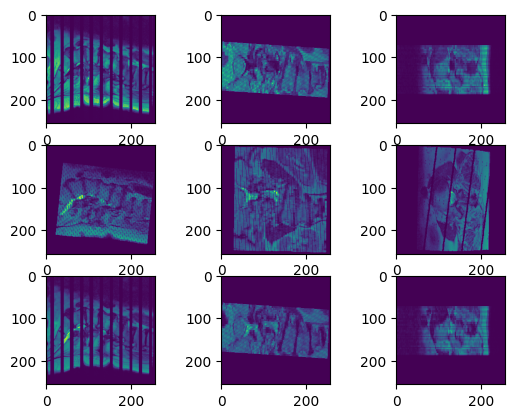

In [79]:
import matplotlib.pyplot as plt
import glob 
import torch

grid = dataset[0][0]

fig, axs = plt.subplots(3, 3)

axs[0, 0].imshow(grid[0, 128])
axs[1, 0].imshow(grid[1, 128])
axs[2, 0].imshow(grid[2, 128])

axs[0, 1].imshow(grid[0, :, 128])
axs[1, 1].imshow(grid[1, :, 128])
axs[2, 1].imshow(grid[2, :, 128])

axs[0, 2].imshow(grid[0, :, :, 128])
axs[1, 2].imshow(grid[1, :, :, 128])
axs[2, 2].imshow(grid[2, :, :, 128])

plt.show()

In [80]:
import torch
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [81]:
import torch.nn as nn
import timm_3d
from spacecutter import *
from spacecutter.losses import *
from spacecutter.models import *
from spacecutter.callbacks import *


class CNN_Model_3D_Multihead(nn.Module):
    def __init__(self,
                 backbone="efficientnet_lite0",
                 in_chans=1,
                 out_classes=5,
                 cutpoint_margin=0.15,
                 pretrained=False):
        super(CNN_Model_3D_Multihead, self).__init__()
        self.out_classes = out_classes

        self.encoder = timm_3d.create_model(
            backbone,
            features_only=False,
            drop_rate=0,
            drop_path_rate=0,
            pretrained=pretrained,
            in_chans=in_chans,
            global_pool="max"
        )
        if "efficientnet" in backbone:
            head_in_dim = self.encoder.classifier.in_features
            self.encoder.classifier = nn.Sequential(
                nn.LayerNorm(head_in_dim),
                nn.Dropout(0),
            )

        elif "vit" in backbone:
            self.encoder.head.drop = nn.Dropout(0)
            head_in_dim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()

        self.heads = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(head_in_dim, 1),
                LogisticCumulativeLink(3)
            ) for i in range(out_classes)]
        )

        self.ascension_callback = AscensionCallback(margin=cutpoint_margin)
    def forward(self, x):
        feat = self.encoder(x)
        return torch.swapaxes(torch.stack([head(feat) for head in self.heads]), 0, 1)

    def _ascension_callback(self):
        for head in self.heads:
            self.ascension_callback.clip(head[-1])

In [82]:
model = CNN_Model_3D_Multihead(backbone="maxvit_rmlp_tiny_rw_256", in_chans=3, out_classes=25).to(device)
model.load_state_dict(torch.load("/kaggle/input/rsna-2024-pytorch-vit-voxel-v2-v6/maxvit_rmlp_tiny_rw_256_256_v2_fold_3_32.pt"))

/tmp/ipykernel_24/3483670522.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/rsna-2024-pytorch-vit-voxel-v2-v6/maxvit_rml

<All keys matched successfully>

In [83]:
CONDITIONS = {
    "Sagittal T2/STIR": ["spinal_canal_stenosis"],
    "Axial T2": ["left_subarticular_stenosis", "right_subarticular_stenosis"],
    "Sagittal T1": ["left_neural_foraminal_narrowing", "right_neural_foraminal_narrowing"],
}

ALL_CONDITIONS = sorted(["spinal_canal_stenosis", "left_subarticular_stenosis", "right_subarticular_stenosis", "left_neural_foraminal_narrowing", "right_neural_foraminal_narrowing"])
LEVELS = ["l1_l2", "l2_l3", "l3_l4", "l4_l5", "l5_s1"]

results_df2 = pd.DataFrame({"row_id":[], "normal_mild": [], "moderate": [], "severe": []})

ALL_CONDITIONS

['left_neural_foraminal_narrowing',
 'left_subarticular_stenosis',
 'right_neural_foraminal_narrowing',
 'right_subarticular_stenosis',
 'spinal_canal_stenosis']

In [84]:
import glob
import os

study_ids = glob.glob("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/*")
study_ids = [os.path.basename(e) for e in study_ids]

results_df2 = pd.DataFrame({"row_id":[], "normal_mild": [], "moderate": [], "severe": []})
for study_id in study_ids:
    for condition in ALL_CONDITIONS:
        for level in LEVELS:
            row_id = f"{study_id}_{condition}_{level}"
            results_df2 = results_df2._append({"row_id": row_id, "normal_mild": 1/3, "moderate": 1/3, "severe": 1/3}, ignore_index=True)

In [85]:
import torch
from torch.cuda.amp import autocast
import time

start_time = time.time()

with torch.no_grad():
    with autocast(dtype=torch.float16):
        model.eval()

        for images, study_id in dataloader:
            output = model(images.to(device))
            for i, batch_out in enumerate(output):
                batch_out = output.cpu().numpy()[i]
                for index, level in enumerate(batch_out):
                    row_id = f"{study_id[i]}_{ALL_CONDITIONS[index // 5]}_{LEVELS[index % 5]}"
                    results_df2.loc[results_df2.row_id == row_id,'normal_mild'] = level[0]
                    results_df2.loc[results_df2.row_id == row_id,'moderate'] = level[1]
                    results_df2.loc[results_df2.row_id == row_id,'severe'] = level[2]
                
print("--- %s seconds ---" % (time.time() - start_time))

/tmp/ipykernel_24/377126589.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):


--- 21.40473198890686 seconds ---


In [86]:
import pandas as pd

# 例として df1 と df2 を作成（実際には適切なデータフレームを使用）
# df1 = pd.DataFrame({...})
# df2 = pd.DataFrame({...})

# データフレームの数値列の平均を計算し、非数値列は元のデータを維持する関数
def average_numeric_values(df1, df2):
    # 両方のデータフレームが同じサイズか確認
    if df1.shape != df2.shape:
        raise ValueError("The two DataFrames must have the same shape.")
    
    # 数値データを選択
    numeric_df1 = df1.select_dtypes(include=['number'])
    numeric_df2 = df2.select_dtypes(include=['number'])
    
    # 数値データを足して2で割る
    averaged_numeric_df = (numeric_df1 + numeric_df2) / 2
    
    # 非数値データを取得
    non_numeric_df = df1.select_dtypes(exclude=['number'])
    
    # 数値と非数値データを結合
    result_df = pd.concat([non_numeric_df, averaged_numeric_df], axis=1)
    
    return result_df

# 2つのデータフレームの対応する数値列を平均し、非数値列を維持
final_df = average_numeric_values(results_df, results_df2)

# 結果の確認
print(final_df)


                                             row_id  normal_mild  moderate  \
0    44036939_left_neural_foraminal_narrowing_l1_l2     0.699879  0.211169   
1    44036939_left_neural_foraminal_narrowing_l2_l3     0.365599  0.543569   
2    44036939_left_neural_foraminal_narrowing_l3_l4     0.261936  0.614878   
3    44036939_left_neural_foraminal_narrowing_l4_l5     0.081399  0.312590   
4    44036939_left_neural_foraminal_narrowing_l5_s1     0.375673  0.261004   
5         44036939_left_subarticular_stenosis_l1_l2     0.415822  0.441576   
6         44036939_left_subarticular_stenosis_l2_l3     0.127632  0.334031   
7         44036939_left_subarticular_stenosis_l3_l4     0.120814  0.377240   
8         44036939_left_subarticular_stenosis_l4_l5     0.089653  0.350726   
9         44036939_left_subarticular_stenosis_l5_s1     0.100908  0.376876   
10  44036939_right_neural_foraminal_narrowing_l1_l2     0.523864  0.339964   
11  44036939_right_neural_foraminal_narrowing_l2_l3     0.642469

In [87]:
results_df

,row_id,normal_mild,moderate,severe
0,44036939_left_neural_foraminal_narrowing_l1_l2,0.983727,0.015535,0.000738
1,44036939_left_neural_foraminal_narrowing_l2_l3,0.180041,0.706840,0.113118
2,44036939_left_neural_foraminal_narrowing_l3_l4,0.220756,0.688693,0.090551
3,44036939_left_neural_foraminal_narrowing_l4_l5,0.015924,0.123525,0.860551
4,44036939_left_neural_foraminal_narrowing_l5_s1,0.700674,0.291027,0.008299
5,44036939_left_subarticular_stenosis_l1_l2,0.238583,0.558313,0.203104
6,44036939_left_subarticular_stenosis_l2_l3,0.016554,0.146600,0.836846
7,44036939_left_subarticular_stenosis_l3_l4,0.032233,0.216221,0.751547
8,44036939_left_subarticular_stenosis_l4_l5,0.028284,0.211042,0.760675
9,44036939_left_subarticular_stenosis_l5_s1,0.151189,0.498917,0.349893


In [88]:
results_df2

,row_id,normal_mild,moderate,severe
0,44036939_left_neural_foraminal_narrowing_l1_l2,0.416031,0.406802,0.177167
1,44036939_left_neural_foraminal_narrowing_l2_l3,0.551157,0.380298,0.068545
2,44036939_left_neural_foraminal_narrowing_l3_l4,0.303115,0.541064,0.155821
3,44036939_left_neural_foraminal_narrowing_l4_l5,0.146874,0.501656,0.351471
4,44036939_left_neural_foraminal_narrowing_l5_s1,0.050672,0.230981,0.718347
5,44036939_left_subarticular_stenosis_l1_l2,0.593061,0.324840,0.082099
6,44036939_left_subarticular_stenosis_l2_l3,0.238710,0.521463,0.239828
7,44036939_left_subarticular_stenosis_l3_l4,0.209394,0.538259,0.252347
8,44036939_left_subarticular_stenosis_l4_l5,0.151021,0.490411,0.358567
9,44036939_left_subarticular_stenosis_l5_s1,0.050627,0.254834,0.694538


In [89]:
final_df

,row_id,normal_mild,moderate,severe
0,44036939_left_neural_foraminal_narrowing_l1_l2,0.699879,0.211169,0.088952
1,44036939_left_neural_foraminal_narrowing_l2_l3,0.365599,0.543569,0.090832
2,44036939_left_neural_foraminal_narrowing_l3_l4,0.261936,0.614878,0.123186
3,44036939_left_neural_foraminal_narrowing_l4_l5,0.081399,0.312590,0.606011
4,44036939_left_neural_foraminal_narrowing_l5_s1,0.375673,0.261004,0.363323
5,44036939_left_subarticular_stenosis_l1_l2,0.415822,0.441576,0.142601
6,44036939_left_subarticular_stenosis_l2_l3,0.127632,0.334031,0.538337
7,44036939_left_subarticular_stenosis_l3_l4,0.120814,0.377240,0.501947
8,44036939_left_subarticular_stenosis_l4_l5,0.089653,0.350726,0.559621
9,44036939_left_subarticular_stenosis_l5_s1,0.100908,0.376876,0.522216


In [90]:
submission_path = '/kaggle/working/submission.csv'
final_df.to_csv(submission_path, index=False)